In [1]:
import pandas as pd
import numpy as np
import scipy
import math
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#wczytanie i zlaczenie plikow
allFiles = ['dane.csv', 'dane2.csv', 'dane3.csv']
data = []
for f in allFiles:
    df = pd.read_csv(f, sep=';')
    data.append(df)
frame = pd.merge(data[0], data[1], on='Data')
frame = pd.merge(frame, data[2], on='Data')

In [3]:
frame[0:3]

Data  poziom wody w piezometrze B1 npm [cm]  \
0  2008-09-23                                  67.21   
1  2008-09-24                                  66.29   
2  2008-09-25                                  65.21   

   temperatura wody w piezometrze B1 [C]  poziom morza  \
0                                  12.57        493.50   
1                                  12.56        490.67   
2                                  12.54        486.67   

   poziom morza  [cm] npm  Opady  Temperatura powietrza [C]  Prędkość wiatru  \
0                  -14.50    0.0                      12.13             3.88   
1                  -17.33    0.0                      10.86             4.50   
2                  -21.33    0.0                      10.05             2.63   

   Kierunek wiatru  Unnamed: 5  Unnamed: 6 kierunki wiatru zakres kąta  
0            66.25         NaN         NaN               N      0<22,5  
1            53.75         NaN         NaN              NE   22,5-67,5  
2            30.00         NaN         NaN               E  67,5-112,5

In [4]:
#zmiana nazw kolumn
columns = { 'Data' : 'date', 'poziom wody w piezometrze B1 npm [cm]': 'waterlv',
            'temperatura wody w piezometrze B1 [C]': 'watertemp',
            'poziom morza': 'sealv',
            'Opady' : 'precip', 'Temperatura powietrza [C]': 'temp',
            'Prędkość wiatru' : 'vwind', 'Kierunek wiatru' : 'dwind' }
frame = frame[list(columns.keys())].rename(columns=columns)

In [5]:
frame[0:3]

date  waterlv  watertemp   sealv  precip   temp  vwind  dwind
0  2008-09-23    67.21      12.57  493.50     0.0  12.13   3.88  66.25
1  2008-09-24    66.29      12.56  490.67     0.0  10.86   4.50  53.75
2  2008-09-25    65.21      12.54  486.67     0.0  10.05   2.63  30.00

In [6]:
frame.shape

(2139, 8)

In [7]:
#zamiana kolumny z datami na typ datetime
frame['date'] = pd.to_datetime(frame['date'])
print (frame['date'].dtype)
frame.set_index(frame["date"],inplace=True)
#suma poziomu wody w piezometrze dla miesiecy
df1 = frame['waterlv'].resample('M', how='sum')

datetime64[ns]


In [8]:
#zamiana na radiany
frame['wind'] = frame['dwind'].apply(math.radians)
#sin
frame['sin'] = frame['wind'].apply(math.sin)
#cos
frame['cos'] = frame['wind'].apply(math.cos)

In [9]:
frame[0:3]

date  waterlv  watertemp   sealv  precip   temp  vwind  \
date                                                                      
2008-09-23 2008-09-23    67.21      12.57  493.50     0.0  12.13   3.88   
2008-09-24 2008-09-24    66.29      12.56  490.67     0.0  10.86   4.50   
2008-09-25 2008-09-25    65.21      12.54  486.67     0.0  10.05   2.63   

            dwind      wind       sin       cos  
date                                             
2008-09-23  66.25  1.156281  0.915311  0.402747  
2008-09-24  53.75  0.938114  0.806445  0.591310  
2008-09-25  30.00  0.523599  0.500000  0.866025

In [10]:
#tworzenie kolumn z wartosciami opadow od 1 do 5 dni wstecz
def precip_before(date, days_count):
    key = date - timedelta(days=days_count)
    if key in frame.index:
        return frame.loc[key]['precip']
    else:
        return None
    
for i in range(1,6):
    frame['precip'+ str(i)] = frame['date'].apply(lambda x : precip_before(x, i))

In [11]:
frame[10:13]

date  waterlv  watertemp   sealv  precip  temp  vwind  \
date                                                                     
2008-10-03 2008-10-03    63.72      12.39  506.17     0.2  9.19   7.00   
2008-10-04 2008-10-04    65.63      12.37  506.50     0.0  8.95   6.38   
2008-10-05 2008-10-05    66.91      12.35  483.67     0.5  8.83   7.88   

             dwind      wind       sin       cos  precip1  precip2  precip3  \
date                                                                          
2008-10-03  211.25  3.687008 -0.518773 -0.854912      0.0      9.6      2.4   
2008-10-04  225.00  3.926991 -0.707107 -0.707107      0.2      0.0      9.6   
2008-10-05  198.75  3.468842 -0.321439 -0.946930      0.0      0.2      0.0   

            precip4  precip5  
date                          
2008-10-03      5.7      0.9  
2008-10-04      2.4      5.7  
2008-10-05      9.6      2.4

In [12]:
#tworzenie kolumny z suma opadow 5 dni wstecz
try:
    frame['precipsum']=frame.iloc[:,11:16].sum(axis=1)
except:
    None
        

In [13]:
frame[0:3]

date  waterlv  watertemp   sealv  precip   temp  vwind  \
date                                                                      
2008-09-23 2008-09-23    67.21      12.57  493.50     0.0  12.13   3.88   
2008-09-24 2008-09-24    66.29      12.56  490.67     0.0  10.86   4.50   
2008-09-25 2008-09-25    65.21      12.54  486.67     0.0  10.05   2.63   

            dwind      wind       sin       cos  precip1  precip2  precip3  \
date                                                                         
2008-09-23  66.25  1.156281  0.915311  0.402747      NaN      NaN      NaN   
2008-09-24  53.75  0.938114  0.806445  0.591310      0.0      NaN      NaN   
2008-09-25  30.00  0.523599  0.500000  0.866025      0.0      0.0      NaN   

            precip4  precip5  precipsum  
date                                     
2008-09-23      NaN      NaN        0.0  
2008-09-24      NaN      NaN        0.0  
2008-09-25      NaN      NaN        0.0

In [14]:
#tworzenie kolumny ze srednia temperatura dla 5 dni wstecz
def mean_temp5(date):
    tlist = []
    for i in range(1,6):
        key = date - timedelta(days=i)
        if key in frame.index:
            tlist.append(frame.loc[key]['temp'])
        else:
            return None
    return np.mean(tlist)

frame['meantemp'] = frame['date'].apply(mean_temp5)

In [15]:
frame[0:3]

date  waterlv  watertemp   sealv  precip   temp  vwind  \
date                                                                      
2008-09-23 2008-09-23    67.21      12.57  493.50     0.0  12.13   3.88   
2008-09-24 2008-09-24    66.29      12.56  490.67     0.0  10.86   4.50   
2008-09-25 2008-09-25    65.21      12.54  486.67     0.0  10.05   2.63   

            dwind      wind       sin       cos  precip1  precip2  precip3  \
date                                                                         
2008-09-23  66.25  1.156281  0.915311  0.402747      NaN      NaN      NaN   
2008-09-24  53.75  0.938114  0.806445  0.591310      0.0      NaN      NaN   
2008-09-25  30.00  0.523599  0.500000  0.866025      0.0      0.0      NaN   

            precip4  precip5  precipsum  meantemp  
date                                               
2008-09-23      NaN      NaN        0.0       NaN  
2008-09-24      NaN      NaN        0.0       NaN  
2008-09-25      NaN      NaN        0.0       NaN

In [16]:
# usuniecie wierszy z NaN
frame = frame.dropna()
frame[0:3]

date  waterlv  watertemp   sealv  precip   temp  vwind  \
date                                                                      
2008-09-28 2008-09-28    62.59      12.49  479.33     0.9  13.15   7.75   
2008-09-29 2008-09-29    61.62      12.47  493.00     5.7  10.96   6.13   
2008-09-30 2008-09-30    61.48      12.44  492.00     2.4  10.29   6.13   

            dwind      wind       sin       cos  precip1  precip2  precip3  \
date                                                                         
2008-09-28  255.0  4.450590 -0.965926 -0.258819      0.0      0.0      0.0   
2008-09-29  240.0  4.188790 -0.866025 -0.500000      0.9      0.0      0.0   
2008-09-30  207.5  3.621558 -0.461749 -0.887011      5.7      0.9      0.0   

            precip4  precip5  precipsum  meantemp  
date                                               
2008-09-28      0.0      0.0        0.0    11.116  
2008-09-29      0.0      0.0        0.9    11.320  
2008-09-30      0.0      0.0        6.6    11.340

In [17]:
# zapis do pliku csv
frame.to_csv('result.csv')

**Eksploracyjna analiza danych**

In [18]:
#shape
frame.shape
type(frame)

pandas.core.frame.DataFrame

In [19]:
#data types
print(frame.dtypes)

date         datetime64[ns]
waterlv             float64
watertemp           float64
sealv               float64
precip              float64
temp                float64
vwind               float64
dwind               float64
wind                float64
sin                 float64
cos                 float64
precip1             float64
precip2             float64
precip3             float64
precip4             float64
precip5             float64
precipsum           float64
meantemp            float64
dtype: object


In [20]:
#head
frame.head(5)

date  waterlv  watertemp   sealv  precip   temp  vwind  \
date                                                                      
2008-09-28 2008-09-28    62.59      12.49  479.33     0.9  13.15   7.75   
2008-09-29 2008-09-29    61.62      12.47  493.00     5.7  10.96   6.13   
2008-09-30 2008-09-30    61.48      12.44  492.00     2.4  10.29   6.13   
2008-10-01 2008-10-01    61.23      12.42  493.50     9.6  11.06   9.25   
2008-10-02 2008-10-02    61.33      12.40  497.83     0.0  10.30  11.38   

             dwind      wind       sin       cos  precip1  precip2  precip3  \
date                                                                          
2008-09-28  255.00  4.450590 -0.965926 -0.258819      0.0      0.0      0.0   
2008-09-29  240.00  4.188790 -0.866025 -0.500000      0.9      0.0      0.0   
2008-09-30  207.50  3.621558 -0.461749 -0.887011      5.7      0.9      0.0   
2008-10-01  213.75  3.730641 -0.555570 -0.831470      2.4      5.7      0.9   
2008-10-02  220.00  3.839724 -0.642788 -0.766044      9.6      2.4      5.7   

            precip4  precip5  precipsum  meantemp  
date                                               
2008-09-28      0.0      0.0        0.0    11.116  
2008-09-29      0.0      0.0        0.9    11.320  
2008-09-30      0.0      0.0        6.6    11.340  
2008-10-01      0.0      0.0        9.0    11.388  
2008-10-02      0.9      0.0       18.6    11.692

In [21]:
#descriptions
print(frame.describe())

           waterlv    watertemp        sealv       precip         temp  \
count  2129.000000  2129.000000  2129.000000  2129.000000  2129.000000   
mean     89.282353     9.550714   506.334171     1.905838     7.919333   
std      21.178420     2.011780    19.060688     4.318492     7.436094   
min      48.500000     6.320000   449.270000     0.000000   -16.580000   
25%      73.500000     7.690000   494.330000     0.000000     2.630000   
50%      87.260000     9.330000   506.000000     0.090000     7.590000   
75%     106.910000    11.570000   516.600000     1.700000    13.980000   
max     146.330000    12.800000   611.440000    47.000000    27.810000   

             vwind        dwind         wind          sin          cos  \
count  2129.000000  2129.000000  2129.000000  2129.000000  2129.000000   
mean      4.606801   180.649624     3.152931    -0.077259    -0.412117   
std       2.243889    70.911251     1.237635     0.746914     0.516428   
min       0.380000    13.750000     0

In [22]:
#usuniecie kolumn ze zbioru
df = frame[frame.columns.difference(['date', 'wind', 'dwind'])]
framey = df[df.columns.difference(['waterlv'])]
df[0:3]

cos  meantemp  precip  precip1  precip2  precip3  precip4  \
date                                                                         
2008-09-28 -0.258819    11.116     0.9      0.0      0.0      0.0      0.0   
2008-09-29 -0.500000    11.320     5.7      0.9      0.0      0.0      0.0   
2008-09-30 -0.887011    11.340     2.4      5.7      0.9      0.0      0.0   

            precip5  precipsum   sealv       sin   temp  vwind  waterlv  \
date                                                                      
2008-09-28      0.0        0.0  479.33 -0.965926  13.15   7.75    62.59   
2008-09-29      0.0        0.9  493.00 -0.866025  10.96   6.13    61.62   
2008-09-30      0.0        6.6  492.00 -0.461749  10.29   6.13    61.48   

            watertemp  
date                   
2008-09-28      12.49  
2008-09-29      12.47  
2008-09-30      12.44

In [23]:
#correlation
corr = frame.corr(method = 'pearson')
print(corr)

            waterlv  watertemp     sealv    precip      temp     vwind  \
waterlv    1.000000  -0.098659  0.359107  0.005270 -0.337894 -0.000283   
watertemp -0.098659   1.000000  0.341774  0.155111  0.539043 -0.009573   
sealv      0.359107   0.341774  1.000000  0.176834  0.149137  0.053729   
precip     0.005270   0.155111  0.176834  1.000000  0.144730  0.126234   
temp      -0.337894   0.539043  0.149137  0.144730  1.000000  0.026328   
vwind     -0.000283  -0.009573  0.053729  0.126234  0.026328  1.000000   
dwind      0.068600   0.081435  0.158080  0.076639  0.069502  0.357772   
wind       0.068600   0.081435  0.158080  0.076639  0.069502  0.357772   
sin       -0.058936  -0.066363 -0.144572 -0.083203 -0.085488 -0.424402   
cos       -0.024073  -0.119819  0.119697 -0.055976  0.025587  0.133401   
precip1    0.026013   0.157001  0.230579  0.176040  0.116302  0.188780   
precip2    0.058660   0.158838  0.191014  0.095769  0.100086  0.053903   
precip3    0.079909   0.159606  0.1739

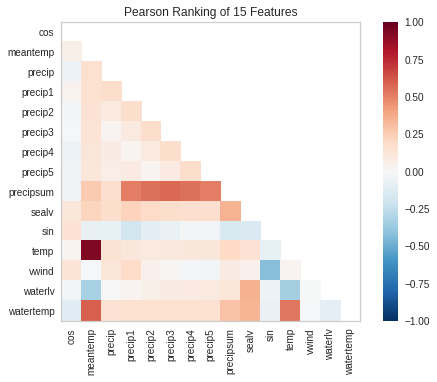

In [24]:
#macierz korelacji
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df)
visualizer.poof()

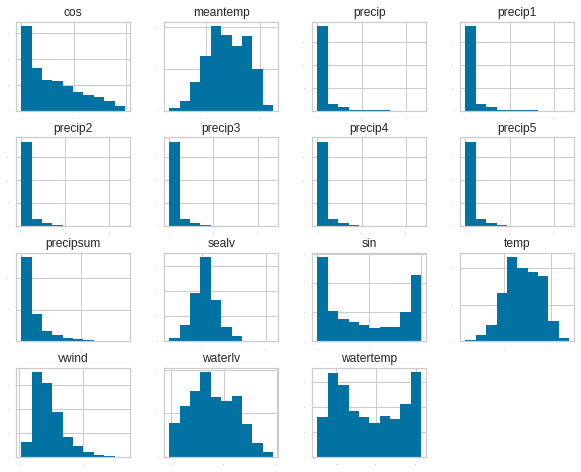

In [25]:
import matplotlib.pyplot as plt
#histograms
plt.rcParams['figure.figsize'] = [10, 8]
df.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize = 1)
plt.show()

In [26]:
import seaborn as sns
sns.set(style="ticks")

#sns.pairplot(data=frame, kind="reg")

In [27]:
#skewness
skew = frame.skew()
print(skew)

waterlv      0.192278
watertemp    0.136306
sealv        0.428498
precip       4.210356
temp        -0.154314
vwind        1.160223
dwind       -0.320087
wind        -0.320087
sin          0.172266
cos          0.735983
precip1      4.203751
precip2      4.198780
precip3      4.211221
precip4      4.211071
precip5      4.206216
precipsum    1.983224
meantemp    -0.150414
dtype: float64


In [28]:
# funkcje wykonujaca transfromacje danych
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


def getInverse(transformer, columns, x):
    inv = transformer.inverse_transform(x)
    inv = pd.DataFrame(inv)
    inv.columns = columns
    return inv

def transform(tr, x):
    tr = tr.fit(x)
    transformed = tr.transform(x)
    transformed = pd.DataFrame(transformed)
    transformed.columns = x.columns
    inverse = lambda inv: getInverse(tr, x.columns, inv)
    return transformed, inverse

def transformY(invTrans, y):
    _, cols = df.shape
    rows = y.shape[0]
    temp = np.zeros((rows, cols))
    temp[:, df.columns.get_loc("waterlv")] = y
    return np.array(invTrans(temp)['waterlv'])


pt, invPt = transform(PowerTransformer(), df)
qt, invQt = transform(QuantileTransformer(), df)

In [29]:
pt[0:3]

cos  meantemp    precip   precip1   precip2  precip3   precip4  \
0  0.506686  0.442775  0.621362 -0.887044 -0.886836 -0.88572 -0.884847   
1 -0.000770  0.471049  1.588824  0.618927 -0.886836 -0.88572 -0.884847   
2 -1.002154  0.473821  1.252593  1.587313  0.616872 -0.88572 -0.884847   

    precip5  precipsum     sealv       sin      temp     vwind   waterlv  \
0 -0.884599  -1.557798 -1.489672 -1.234428  0.703069  1.343533 -1.307498   
1 -0.884599  -0.995177 -0.680707 -1.077695  0.405022  0.832361 -1.362830   
2 -0.884599   0.224872 -0.737806 -0.466255  0.313974  0.832361 -1.370855   

   watertemp  
0   1.383112  
1   1.375174  
2   1.363247

In [30]:
qt[0:3]

cos  meantemp    precip       precip1       precip2       precip3  \
0  0.660661  0.632516  0.683684  1.000000e-07  1.000000e-07  1.000000e-07   
1  0.527528  0.639579  0.893894  6.836837e-01  1.000000e-07  1.000000e-07   
2  0.237738  0.640461  0.791291  8.933934e-01  6.836837e-01  1.000000e-07   

        precip4       precip5     precipsum     sealv       sin      temp  \
0  1.000000e-07  1.000000e-07  1.000000e-07  0.069069  0.121121  0.707708   
1  1.000000e-07  1.000000e-07  2.312312e-01  0.229229  0.227227  0.627385   
2  1.000000e-07  1.000000e-07  5.505506e-01  0.213714  0.417417  0.600601   

      vwind   waterlv  watertemp  
0  0.901902  0.124934   0.938939  
1  0.788789  0.114695   0.935936  
2  0.788789  0.112923   0.931932

In [31]:
df[0:3]

cos  meantemp  precip  precip1  precip2  precip3  precip4  \
date                                                                         
2008-09-28 -0.258819    11.116     0.9      0.0      0.0      0.0      0.0   
2008-09-29 -0.500000    11.320     5.7      0.9      0.0      0.0      0.0   
2008-09-30 -0.887011    11.340     2.4      5.7      0.9      0.0      0.0   

            precip5  precipsum   sealv       sin   temp  vwind  waterlv  \
date                                                                      
2008-09-28      0.0        0.0  479.33 -0.965926  13.15   7.75    62.59   
2008-09-29      0.0        0.9  493.00 -0.866025  10.96   6.13    61.62   
2008-09-30      0.0        6.6  492.00 -0.461749  10.29   6.13    61.48   

            watertemp  
date                   
2008-09-28      12.49  
2008-09-29      12.47  
2008-09-30      12.44

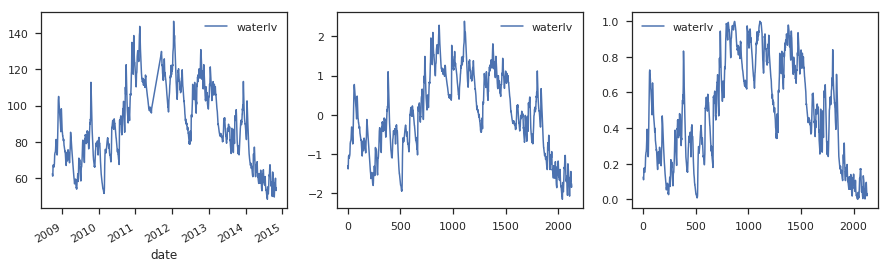

In [32]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
df.plot(y='waterlv', ax=ax1)
pt.plot(y='waterlv', ax=ax2)
qt.plot(y='waterlv', ax=ax3)

In [33]:
pcorr = pt.corr(method = 'pearson')
print(pcorr)

                cos  meantemp    precip   precip1   precip2   precip3  \
cos        1.000000  0.057779 -0.115749  0.008610 -0.038620 -0.030308   
meantemp   0.057779  1.000000  0.037525  0.040945  0.037221  0.025048   
precip    -0.115749  0.037525  1.000000  0.320791  0.128542  0.097410   
precip1    0.008610  0.040945  0.320791  1.000000  0.321788  0.129093   
precip2   -0.038620  0.037221  0.128542  0.321788  1.000000  0.321678   
precip3   -0.030308  0.025048  0.097410  0.129093  0.321678  1.000000   
precip4   -0.078159  0.012302  0.084613  0.097238  0.128552  0.322001   
precip5   -0.067494 -0.000772  0.066484  0.086839  0.098786  0.127036   
precipsum -0.067190  0.184290  0.219883  0.497678  0.546493  0.556498   
sealv      0.115097  0.249574  0.218059  0.307488  0.274971  0.252855   
sin        0.077828 -0.073176 -0.183687 -0.269931 -0.157978 -0.077963   
temp       0.023729  0.930483  0.043467  0.008609 -0.017671 -0.019132   
vwind      0.163841  0.013933  0.201824  0.211991  

In [34]:
waterlv_index = df.columns.get_loc("waterlv")
waterlv_index

13

In [35]:
#split-out validation dataset
from sklearn.model_selection import train_test_split
array = df.values
X = array[:, (0,1,2,3,4,5,6,7,8,9,10,11,12,14)].astype(np.float)
Y = array[:, waterlv_index].astype(np.float)
validation_size = 0.20
seed = 7 
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y, test_size = validation_size, random_state = seed)

In [36]:
#split-out after YeoJohnson transformation
tarray = pt.values
Xt = tarray[:, (0,1,2,3,4,5,6,7,8,9,10,11,12,14)].astype(np.float)
Yt = tarray[:, waterlv_index].astype(np.float)
validation_size = 0.20
seed = 7 
Xt_train, Xt_validation, Yt_train, Yt_validation = train_test_split(Xt,Yt, test_size = validation_size, random_state = seed)

In [37]:
#split-out after Quantile Transformer
qarray = qt.values
Xq = qarray[:, (0,1,2,3,4,5,6,7,8,9,10,11,12,14)].astype(np.float)
Yq = qarray[:, waterlv_index].astype(np.float)
validation_size = 0.20
seed = 7 
Xq_train, Xq_validation, Yq_train, Yq_validation = train_test_split(Xq,Yq, test_size = validation_size, random_state = seed)

In [38]:
def evaluation(clf, X_train, Y_train, X_test, Y_test, invTr = None):
    if invTr is None:
        tr = lambda y: y
    else:
        tr = lambda y: transformY(invTr, y)
    train = tr(Y_train)
    train_pred = tr(clf.predict(X_train))
    test = tr(Y_test)
    test_pred = tr(clf.predict(X_test))
    show_evaluation(train, train_pred, test, test_pred)

def show_evaluation(train, train_pred, test, test_pred):
    print ("RMSE training set:", np.sqrt(mean_squared_error(train, train_pred)))
    print ("RMSE testing set:", np.sqrt(mean_squared_error(test, test_pred)))
    print ("MAE training set:", mean_absolute_error(train, train_pred))
    print ("MAE testing set:", mean_absolute_error(test, test_pred))
    
    fig, ax = plt.subplots()
    trainplot = sns.scatterplot(train,train_pred, label='train')
    testplot = sns.scatterplot(test,test_pred, label='test')
    plt.xlabel('waterlv')
    plt.ylabel('Predicted Value')
    plt.legend(loc="upper left")
    plt.show()
    

In [39]:
def evaluateClf(clf, params):
    orig_clf = clf(**params)
    pt_clf = clf(**params)
    qt_clf = clf(**params)
    print(orig_clf)
    
    orig_clf.fit(X_train, Y_train)
    pt_clf.fit(Xt_train, Yt_train)
    qt_clf.fit(Xq_train, Yq_train)
    
    evaluation(orig_clf, X_train, Y_train, X_validation, Y_validation)
    evaluation(pt_clf, Xt_train, Yt_train, Xt_validation, Yt_validation, invPt)
    evaluation(qt_clf, Xq_train, Yq_train, Xq_validation, Yq_validation, invQt)

**Random Forest**

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RMSE training set: 12.904068140309075
RMSE testing set: 14.928845337765203
MAE training set: 10.76263758605887
MAE testing set: 12.490591940361016


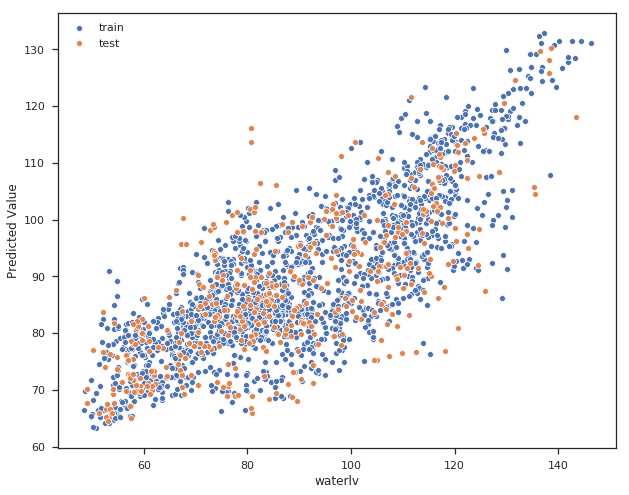

RMSE training set: 12.886745583556527
RMSE testing set: 14.977684110268207
MAE training set: 10.684418609908732
MAE testing set: 12.3938517778197


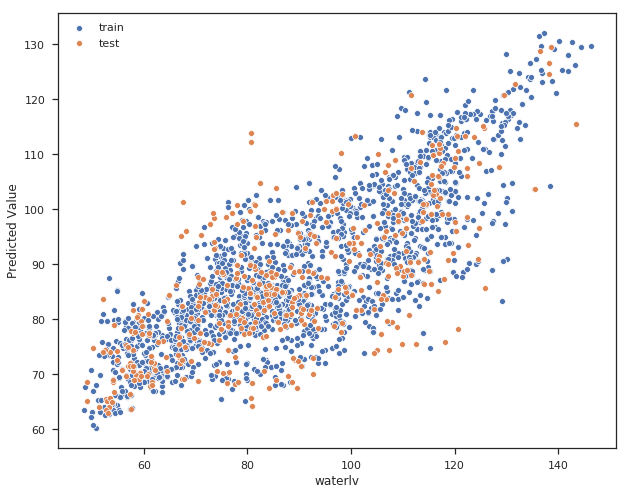

RMSE training set: 13.493150635958248
RMSE testing set: 15.32220962153072
MAE training set: 11.139565387937436
MAE testing set: 12.738005846063128


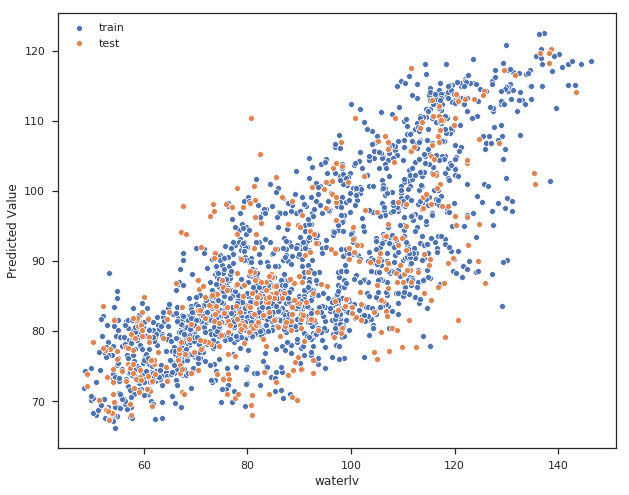

In [40]:
from sklearn.ensemble import RandomForestRegressor
evaluateClf(RandomForestRegressor, { 'n_estimators':200, 'max_depth': 6, 'random_state': 0})

**Ridge**

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
RMSE training set: 17.49619375019268
RMSE testing set: 17.676834819595065
MAE training set: 14.815314309469587
MAE testing set: 14.920167278652062


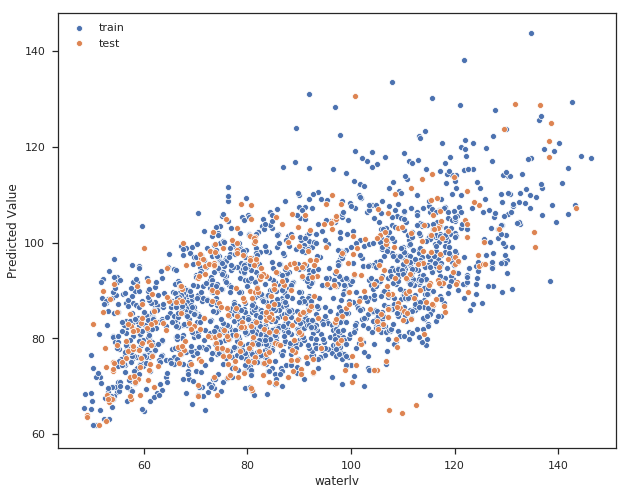

RMSE training set: 17.51913973180264
RMSE testing set: 17.78040145065443
MAE training set: 14.923004270362442
MAE testing set: 14.974485578730858


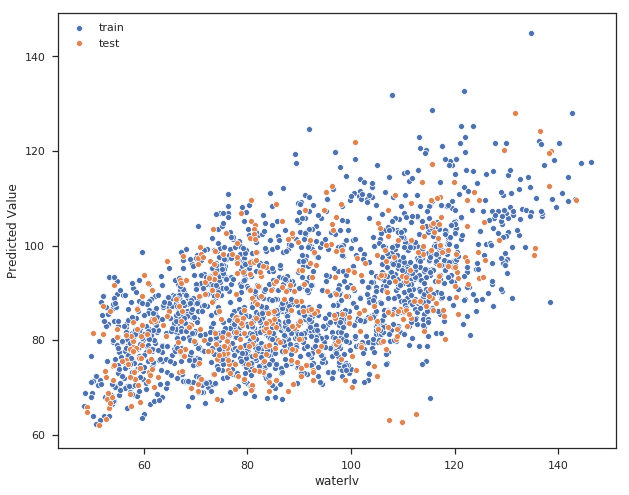

RMSE training set: 17.318775598019286
RMSE testing set: 17.43546101111901
MAE training set: 14.773295691939945
MAE testing set: 14.861202488516783


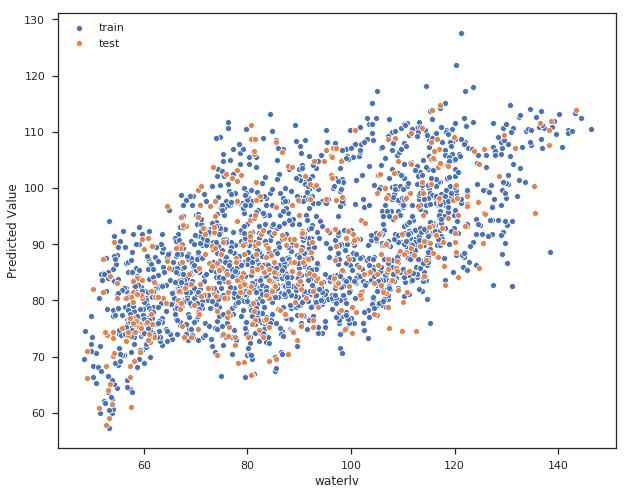

In [41]:
from sklearn import linear_model
evaluateClf(linear_model.Ridge, { 'alpha':.5})

**Lasso**

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
RMSE training set: 17.541713701412753
RMSE testing set: 17.680088953508882
MAE training set: 14.866668788276241
MAE testing set: 14.962602362247136


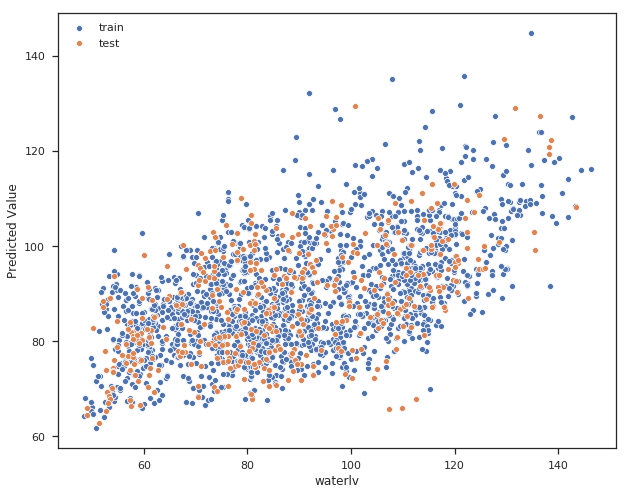

RMSE training set: 21.22092303390009
RMSE testing set: 21.104479900238815
MAE training set: 17.751734697210864
MAE testing set: 17.642379805364875


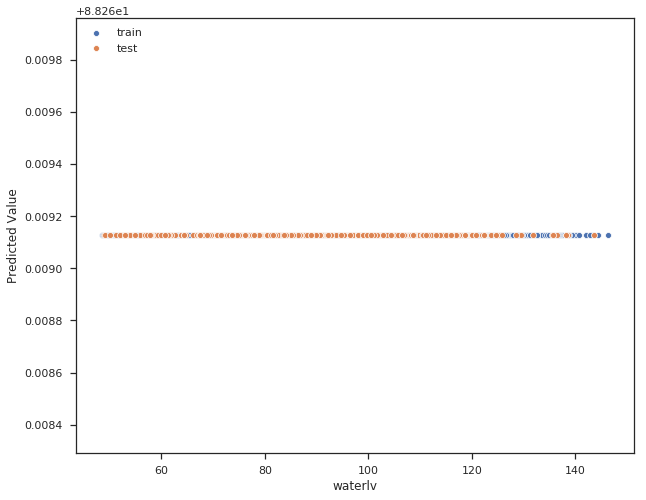

RMSE training set: 21.292324914839654
RMSE testing set: 21.105085633933022
MAE training set: 17.740603477379178
MAE testing set: 17.589658855770423


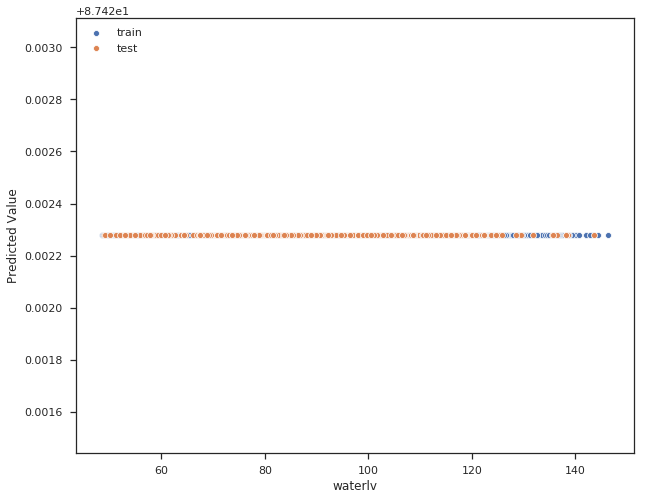

In [42]:
evaluateClf(linear_model.Lasso, { 'alpha':0.5})

**Elastic Net**

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
RMSE training set: 17.4981176968834
RMSE testing set: 17.672664661282045
MAE training set: 14.819245768774232
MAE testing set: 14.926335008635867


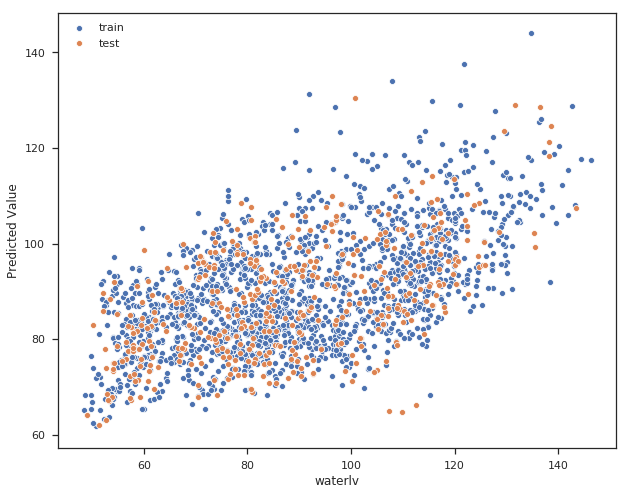

RMSE training set: 17.85486623993367
RMSE testing set: 17.98045726683447
MAE training set: 15.179369350148304
MAE testing set: 15.260608704669808


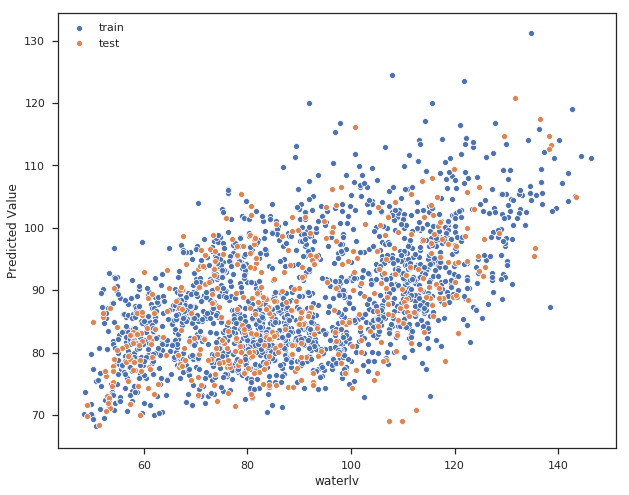

RMSE training set: 21.292324914839654
RMSE testing set: 21.105085633933022
MAE training set: 17.740603477379178
MAE testing set: 17.589658855770423


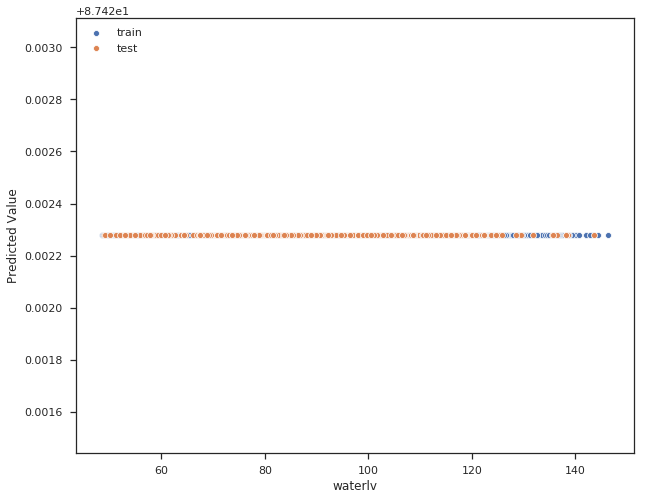

In [43]:
from sklearn.linear_model import ElasticNet
evaluateClf(ElasticNet, { 'alpha':0.1,'random_state':0})

**SVM**

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
RMSE training set: 12.99338432793751
RMSE testing set: 19.528966262751265
MAE training set: 8.714272447267549
MAE testing set: 15.914088199690871


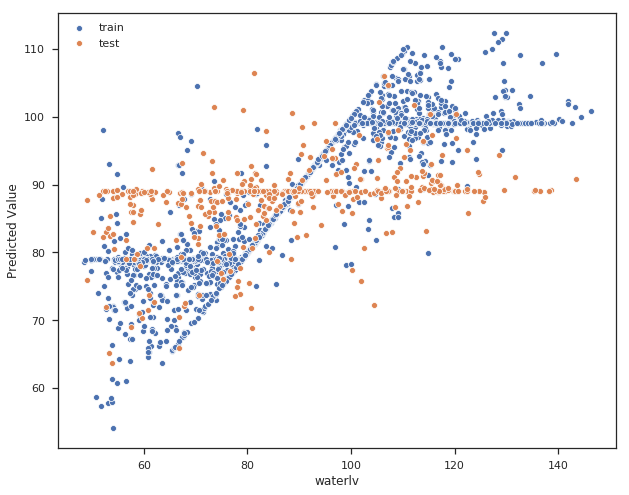

RMSE training set: 9.165736026681223
RMSE testing set: 17.660255031737012
MAE training set: 5.836553040368817
MAE testing set: 13.769958100719016


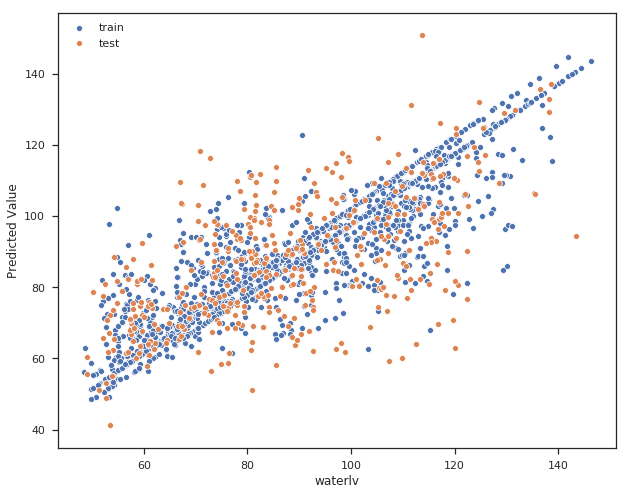

RMSE training set: 15.390889569225912
RMSE testing set: 17.27478217041792
MAE training set: 12.697202382823468
MAE testing set: 14.267795892164749


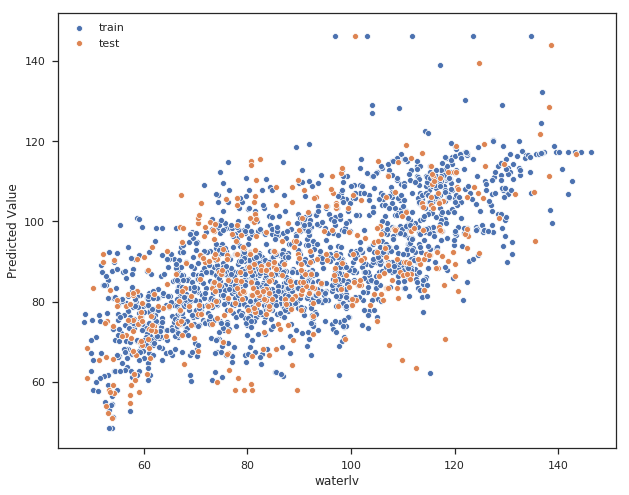

In [44]:
from sklearn import svm
evaluateClf(svm.SVR, {'C':10})

**Stochastic Gradient**

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)
RMSE training set: 62702288982968.16
RMSE testing set: 62484422253565.12
MAE training set: 62617220293375.34
MAE testing set: 62399603530165.875


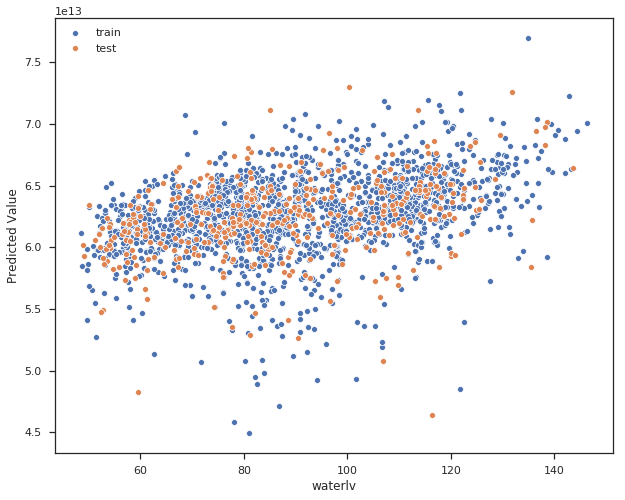

RMSE training set: 17.525272591861928
RMSE testing set: 17.759284856605568
MAE training set: 14.943720823706421
MAE testing set: 14.982841931506599


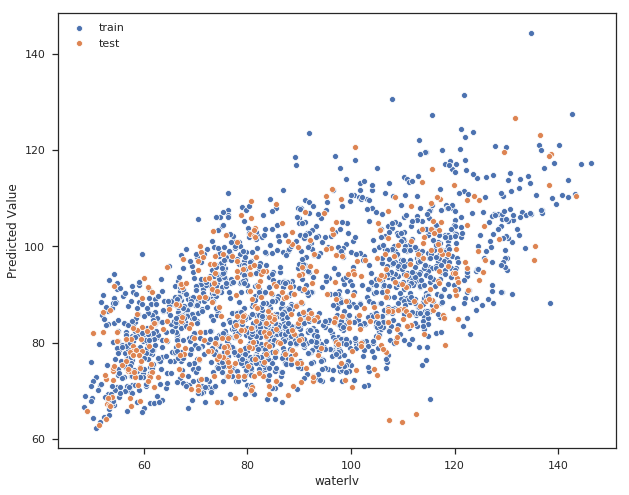

RMSE training set: 18.190112911758106
RMSE testing set: 18.468406872618363
MAE training set: 15.39203041836141
MAE testing set: 15.57633530913616


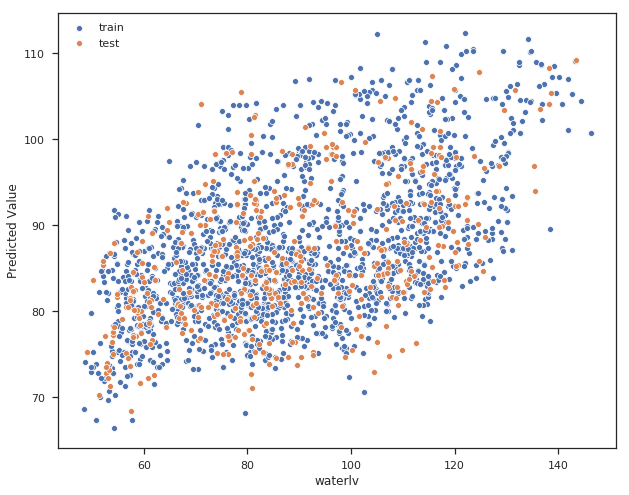

In [45]:
from sklearn.linear_model import SGDClassifier
evaluateClf(linear_model.SGDRegressor, {'max_iter':1000, 'tol':1e-3})

**Nearest Neighbors**

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')
RMSE training set: 14.678436153924523
RMSE testing set: 18.170457097870155
MAE training set: 11.822325308279506
MAE testing set: 15.18156338028169


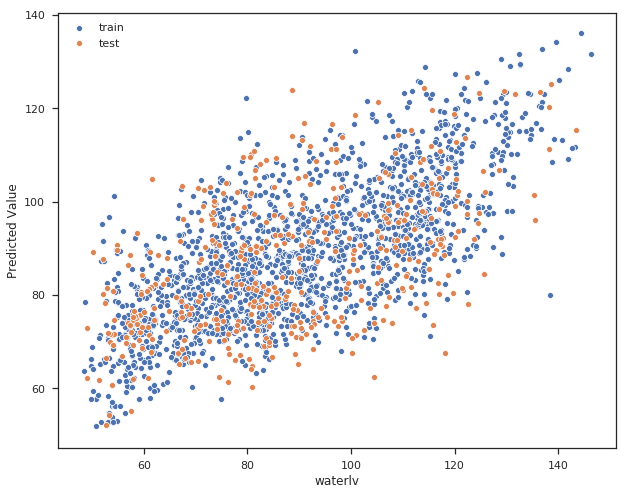

RMSE training set: 15.409696397988833
RMSE testing set: 18.473074093908753
MAE training set: 12.448305864113461
MAE testing set: 15.101203054013633


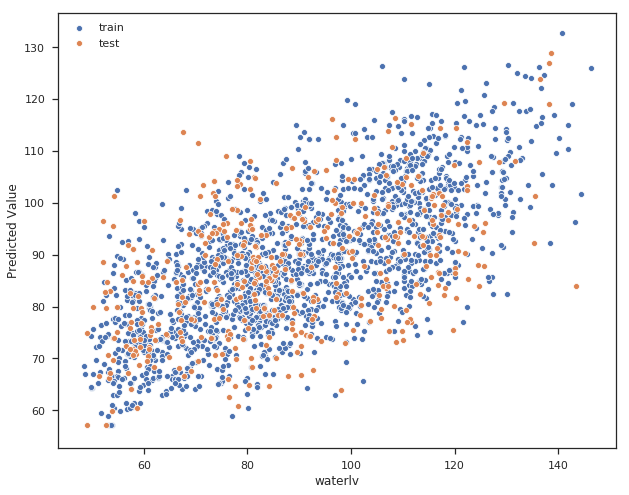

RMSE training set: 15.508305474975986
RMSE testing set: 18.37813700265014
MAE training set: 12.447263158314636
MAE testing set: 14.91178195630211


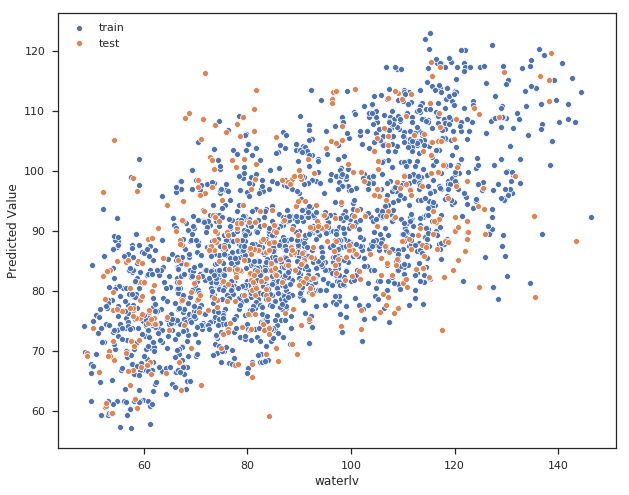

In [46]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, Y_train) 
tneigh = KNeighborsRegressor(n_neighbors=5)
tneigh.fit(Xt_train, Yt_train) 
qneigh = KNeighborsRegressor(n_neighbors=5)
qneigh.fit(Xq_train, Yq_train)
evaluateClf(KNeighborsRegressor, {'n_neighbors':5})

**Robust linear model estimation using RANSAC**


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)
RMSE training set: 21.419391881479534
RMSE testing set: 21.556249705437818
MAE training set: 17.63159324628009
MAE testing set: 17.614273729713968


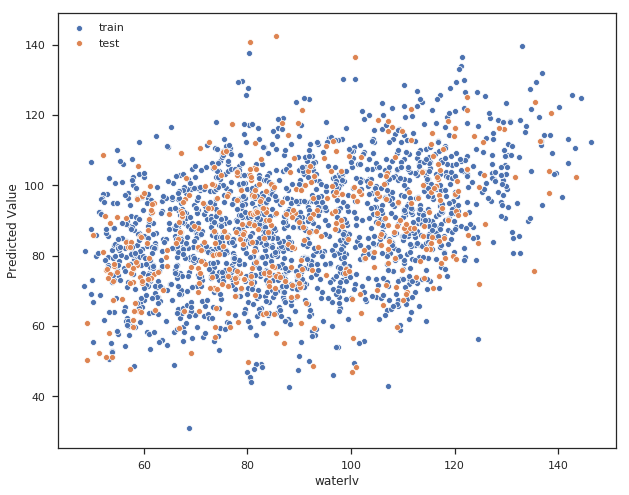

RMSE training set: 28.913710107062236
RMSE testing set: 27.327864553796292
MAE training set: 22.377324945159877
MAE testing set: 21.578799423464957


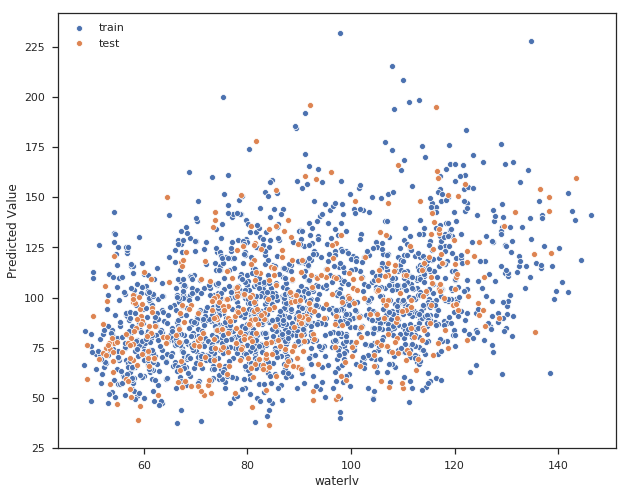

RMSE training set: 25.500093451744995
RMSE testing set: 25.304773385645955
MAE training set: 20.147068158393218
MAE testing set: 20.274355279307294


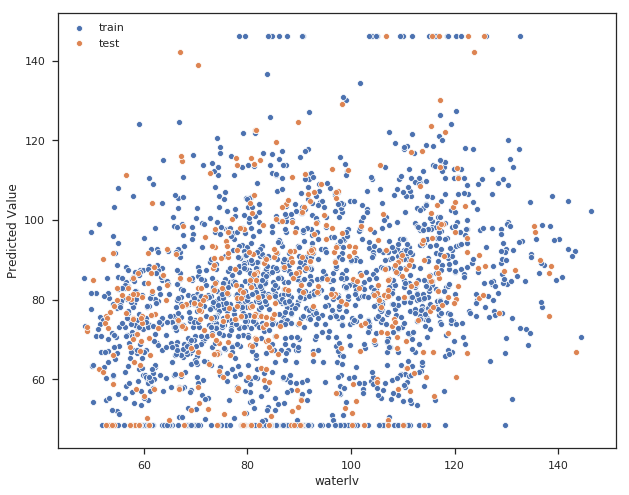

In [47]:
ransac = linear_model.RANSACRegressor()
ransac.fit(X_train, Y_train)
transac = linear_model.RANSACRegressor()
transac.fit(Xt_train, Yt_train) 
qransac = linear_model.RANSACRegressor()
qransac.fit(Xq_train, Yq_train)
evaluateClf(linear_model.RANSACRegressor, {})

**XGBoost**

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=256, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
RMSE training set: 12.682502476854848
RMSE testing set: 14.654050639681977
MAE training set: 10.407412802964465
MAE testing set: 12.083628065440577


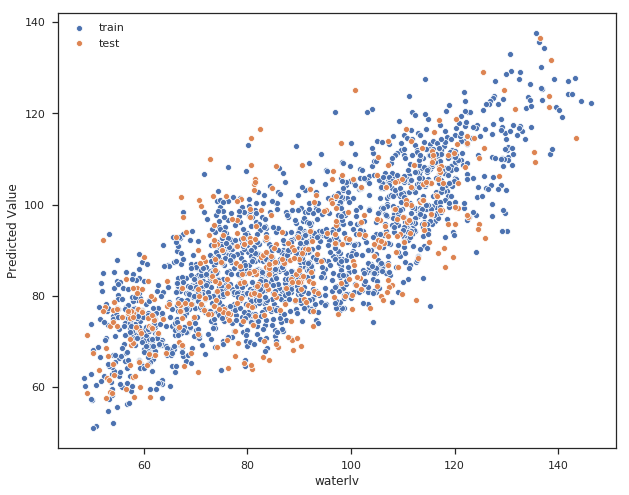

RMSE training set: 12.744253249861764
RMSE testing set: 14.62379466597674
MAE training set: 10.4549148841175
MAE testing set: 12.033886641141022


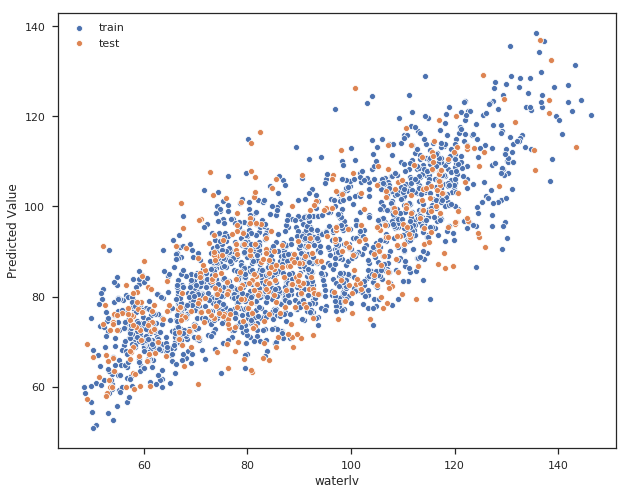

RMSE training set: 13.2032677332541
RMSE testing set: 14.859227669730439
MAE training set: 10.82826389631721
MAE testing set: 12.215322733762312


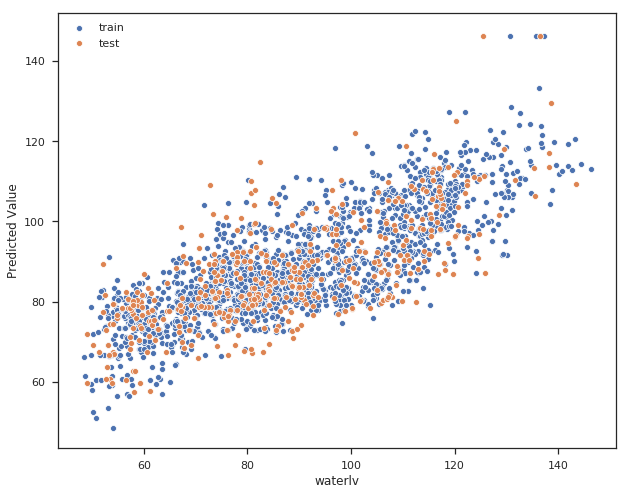

In [48]:
import xgboost as xgb

evaluateClf(xgb.XGBRegressor, { 'max_depth':2, 'n_estimators':256, 'learning_rate':0.10, 'nthread': 4} )

**Analiza głównych składowych - PCA**

In [49]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale
import scipy.spatial.distance as dist
from sklearn.manifold import MDS

In [50]:
pt_scaled = scale(pt)
qt_scaled = scale(qt)

pt_distance = dist.pdist(pt_scaled)
pt_distance = dist.squareform(pt_distance)
pt_punkty = MDS(n_components=2, dissimilarity='precomputed', random_state=1,eps=1e-5,n_init=10).fit_transform(pt_distance)

pca_pt = PCA(8,whiten=True).fit(pt_scaled)
pca_pt.explained_variance_ratio_
pt_components = pca_pt.transform(pt_scaled)

In [51]:
pca_pt.explained_variance_ratio_

array([0.22819307, 0.16116197, 0.10625754, 0.0769338 , 0.07123432,
       0.06738065, 0.05770351, 0.05273907])

In [52]:
qt_distance = dist.pdist(qt_scaled)
qt_distance = dist.squareform(qt_distance)
qt_punkty = MDS(n_components=2, dissimilarity='precomputed', random_state=1,eps=1e-5,n_init=10).fit_transform(qt_distance)

pca_qt = PCA(4,whiten=True).fit(qt_scaled)
pca_qt.explained_variance_ratio_
qt_components = pca_qt.transform(qt_scaled)

In [53]:
pca_qt.explained_variance_ratio_

array([0.21966285, 0.15852475, 0.10428241, 0.08308298])

        var   PC
0  0.228193  PC1
1  0.161162  PC2
2  0.106258  PC3
3  0.076934  PC4
4  0.071234  PC5
5  0.067381  PC6
6  0.057704  PC7
7  0.052739  PC8


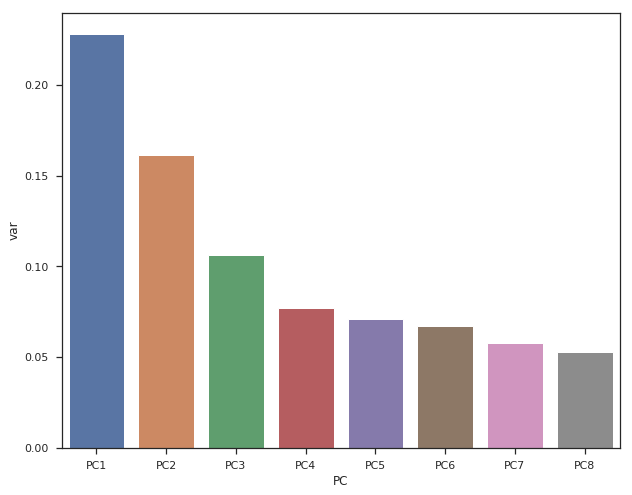

In [54]:
df_pca = pd.DataFrame({'var':pca_pt.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']})
print(df_pca)
sns.barplot(x='PC',y="var", data=df_pca)

**Grupowanie**

In [55]:
pt_scaled = scale(pt)
qt_scaled = scale(qt)

In [56]:
pts_array = pt.values
Xpts = pts_array[:, (0,1,2,3,4,5,6,7,8,9,10,11,12,14)].astype(np.float)
Ypts = pts_array[:, waterlv_index].astype(np.float)

In [57]:
qts_array = qt.values
Xqts = qts_array[:, (0,1,2,3,4,5,6,7,8,9,10,11,12,14)].astype(np.float)
Yqts = qts_array[:, waterlv_index].astype(np.float)

In [58]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

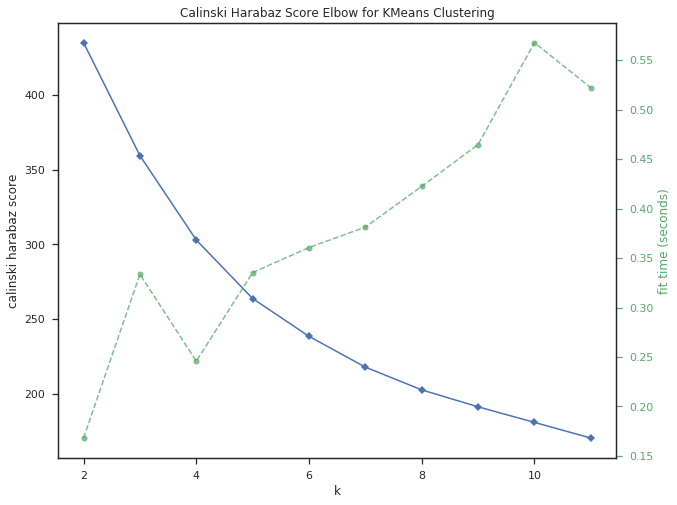

In [59]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12),  metric='calinski_harabaz', locate_elbow=True)

visualizer.fit(Xpts)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [60]:
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import SilhouetteVisualizer

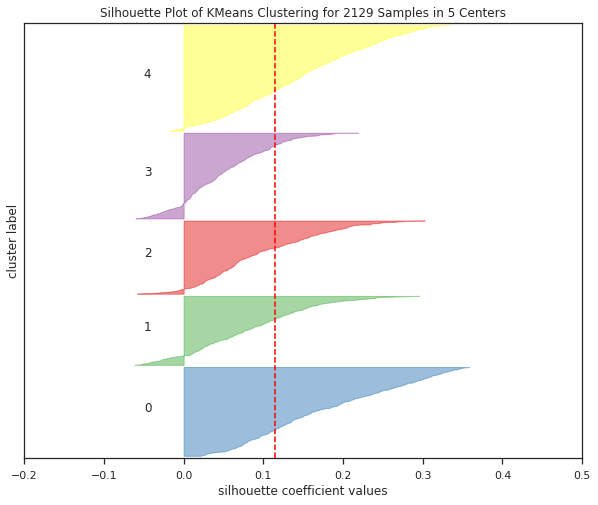

In [61]:
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick', palette="Set3")

visualizer.fit(Xpts)        # Fit the data to the visualizer
visualizer.poof()

In [62]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(Xpts)

y_kmeans = kmeans.predict(Xpts)
y_kmeans

array([0, 0, 2, ..., 0, 0, 0], dtype=int32)

In [63]:
pd.set_option('display.max_columns', 500)
df_clust = df.copy()
df_clust['klasa'] = y_kmeans
grpb = df_clust.groupby('klasa').agg(['mean','std','count'])
grpb

cos                   meantemp                    precip  \
           mean       std count       mean       std count      mean   
klasa                                                                  
0     -0.391231  0.551916   448  13.354281  4.643335   448  1.370960   
1     -0.509713  0.500200   348  13.313839  4.102181   348  1.718563   
2     -0.337193  0.458392   369  12.319030  4.942734   369  4.693659   
3     -0.526184  0.472900   432   2.487361  3.533038   432  1.836366   
4     -0.325207  0.541357   532   1.198271  5.048533   532  0.601523   

                        precip1                   precip2                  \
            std count      mean       std count      mean       std count   
klasa                                                                       
0      3.595386   448  0.347210  1.309493   448  0.309129  1.100832   448   
1      4.287121   348  0.805747  2.670360   348  3.289310  6.617665   348   
2      6.944079   369  6.940759  7.342112   369  4.307019  5.917179   369   
3      3.051270   432  2.018449  3.005513   432  2.260324  3.482808   432   
4      1.869977   532  0.369117  1.082605   532  0.419211  1.169134   532   

        precip3                   precip4                   precip5            \
           mean       std count      mean       std count      mean       std   
klasa                                                                           
0      0.273348  0.935337   448  0.198259  0.651528   448  0.466339  1.469882   
1      4.988879  7.404221   348  5.921580  7.513633   348  4.638908  6.602492   
2      2.657263  4.619010   369  1.636450  3.663274   369  2.467588  5.670448   
3      2.302060  3.561757   432  2.526389  3.689196   432  2.464745  3.707317   
4      0.424492  1.357119   532  0.400695  1.196421   532  0.493026  1.401425   

             precipsum                        sealv                   \
      count       mean        std count        mean        std count   
klasa                                                                  
0       448   1.594286   2.283485   448  504.072924  12.202465   448   
1       348  19.644425  13.231051   348  511.030460  13.984342   348   
2       369  18.009079  13.497659   369  516.669377  18.178918   369   
3       432  11.571968   8.857808   432  515.446991  20.641593   432   
4       532   2.106541   2.579704   532  490.597895  14.809340   532   

            sin                       temp                     vwind  \
           mean       std count       mean       std count      mean   
klasa                                                                  
0      0.079357  0.733424   448  14.004821  5.111435   448  4.038906   
1      0.125947  0.690085   348  13.362701  4.742684   348  3.714368   
2     -0.648679  0.506614   369  11.467696  4.392404   369  6.492981   
3     -0.231624  0.668879   432   2.188889  4.078270   432  4.648727   
4      0.179621  0.755336   532   1.426128  5.446603   532  4.326485   

                          waterlv                   watertemp                  
            std count        mean        std count       mean       std count  
klasa                                                                          
0      1.718577   448   80.765737  19.013127   448  10.558170  1.565339   448  
1      1.409684   348   87.828333  19.597443   348  11.109483  1.508253   348  
2      2.594282   369   86.617290  19.097687   369  10.926287  1.625970   369  
3      2.230370   432  100.768310  21.208006   432   8.465093  1.280828   432  
4      2.084386   532   89.926936  21.191709   532   7.610132  1.005523   532

(array([448.,   0., 348.,   0.,   0., 369.,   0., 432.,   0., 532.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

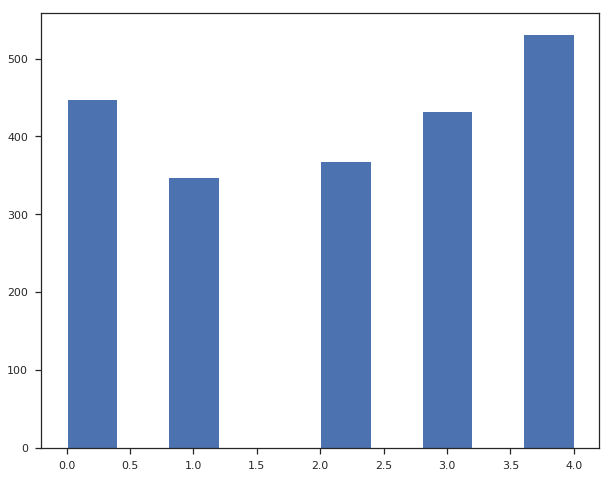

In [64]:
plt.hist(df_clust.klasa)

list

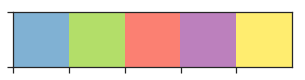

In [65]:
current_palette1 = sns.color_palette('Set3')
first = current_palette1[4]
second = current_palette1[6]
third = current_palette1[3]
fourth = current_palette1[9]
fifth = current_palette1[11]
current_palette = [first, second, third, fourth, fifth]
sns.set_palette(current_palette)

sns.palplot(current_palette)
type(current_palette)

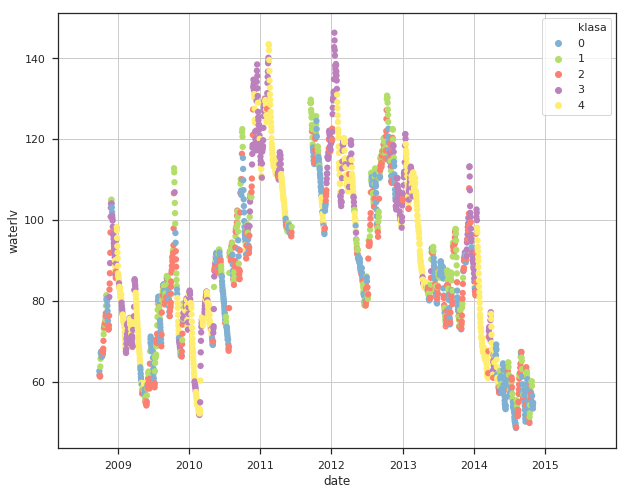

In [66]:
# import seaborn as sns

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10,8]
sns.scatterplot(df_clust.index, df_clust.waterlv, hue=df_clust.klasa, 
                edgecolor="none", palette=current_palette, s=40, legend="full",)

ax.legend(frameon=True)

ax.set(xlim=('2008-03-01','2015-12-31'))
ax.grid(True)
ax.set_ylabel('waterlv')
ax.set_xlabel('date')

plt.show()

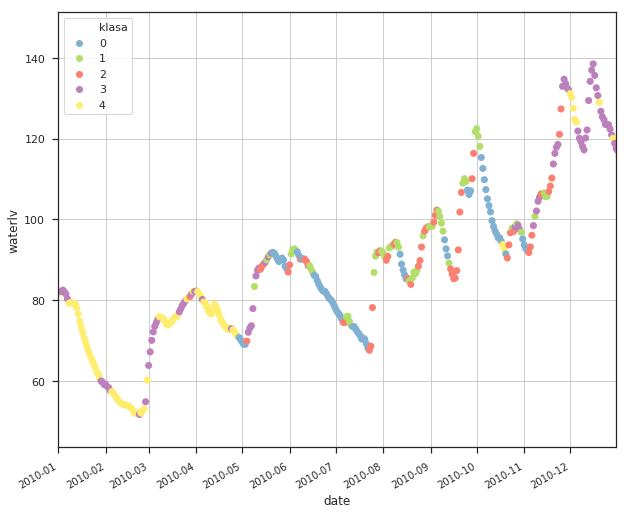

In [67]:
fig, ax = plt.subplots()

sns.scatterplot(df_clust.index, df_clust.waterlv, hue=df_clust.klasa, 
                edgecolor="none", palette=current_palette, s = 50 )
ax.legend(frameon=True)
ax.set(xlim=('2010-01-01','2010-12-31'))
ax.grid(True)
ax.set_ylabel('waterlv')
ax.set_xlabel('date')
plt.xticks(
    rotation=30, 
    horizontalalignment='right', 
    fontsize='small'
)

plt.show()

**Grid Search**
**Random Forest**

In [68]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 20, 30], 'min_samples_split': [0.1,0.3,0.6],
                   'min_samples_leaf': [1,2,4]}

model = RandomForestRegressor(random_state=1)

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 0.1,
 'n_estimators': 10}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.1,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RMSE training set: 16.091740373500823
RMSE testing set: 16.738243697269443
MAE training set: 13.718428443903523
MAE testing set: 14.369701610307024


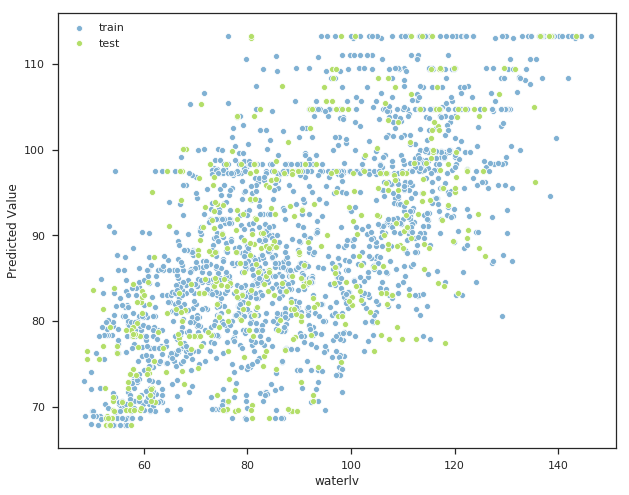

RMSE training set: 16.12882935607081
RMSE testing set: 16.838320002935752
MAE training set: 13.609674807709041
MAE testing set: 14.233700431805246


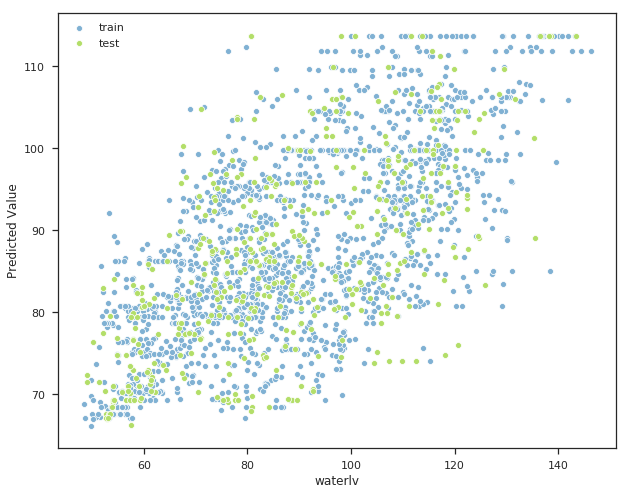

RMSE training set: 16.51983554021653
RMSE testing set: 17.12694151038067
MAE training set: 13.864751035461378
MAE testing set: 14.452391627913078


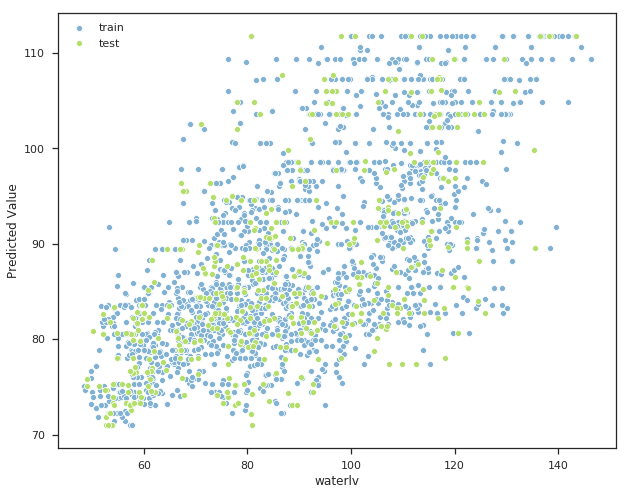

In [69]:
from sklearn.ensemble import RandomForestRegressor
evaluateClf(RandomForestRegressor, { 'n_estimators':10, 'max_depth': 10, 'random_state': 0,
                                   'min_samples_leaf': 1, 'min_samples_split':0.1})

In [70]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': [8, 10,12], 'max_depth': [8, 10, 12], 'min_samples_split': [0.05, 0.1,0.15]}

model = RandomForestRegressor(random_state=1)

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'max_depth': 12, 'min_samples_split': 0.05, 'n_estimators': 12}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.05,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
RMSE training set: 14.594119127352965
RMSE testing set: 15.970465688757303
MAE training set: 12.338391942460087
MAE testing set: 13.471066354932695


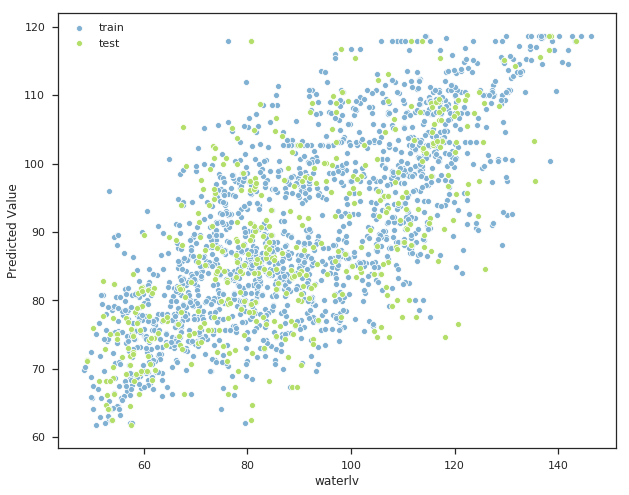

RMSE training set: 14.605226458621058
RMSE testing set: 16.034883951076882
MAE training set: 12.270916931503507
MAE testing set: 13.450984631235217


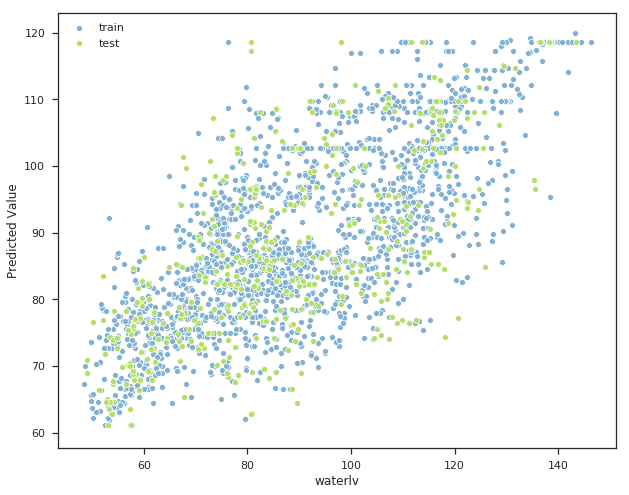

RMSE training set: 14.99467600559211
RMSE testing set: 16.200745533728544
MAE training set: 12.596656100049636
MAE testing set: 13.631983566171725


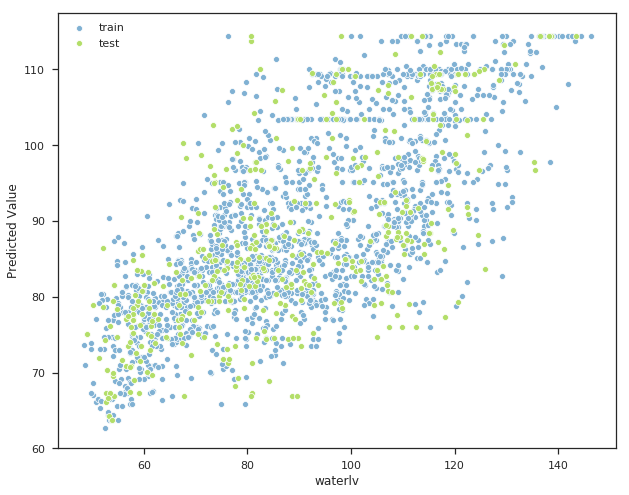

In [71]:
from sklearn.ensemble import RandomForestRegressor
evaluateClf(RandomForestRegressor, { 'n_estimators':10, 'max_depth': 12, 'random_state': 1, 'min_samples_split': 0.05, 'min_samples_leaf': 1})

In [72]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 20, 30]}

model = RandomForestRegressor(random_state=1)

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'max_depth': 20, 'n_estimators': 50}

In [73]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = {'n_estimators': [180, 200, 220], 'max_depth': [18, 20, 22]}

model = RandomForestRegressor(random_state=1)

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'max_depth': 22, 'n_estimators': 200}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
RMSE training set: 5.105709587412972
RMSE testing set: 13.229627237302717
MAE training set: 4.098752095280892
MAE testing set: 10.60313156310853


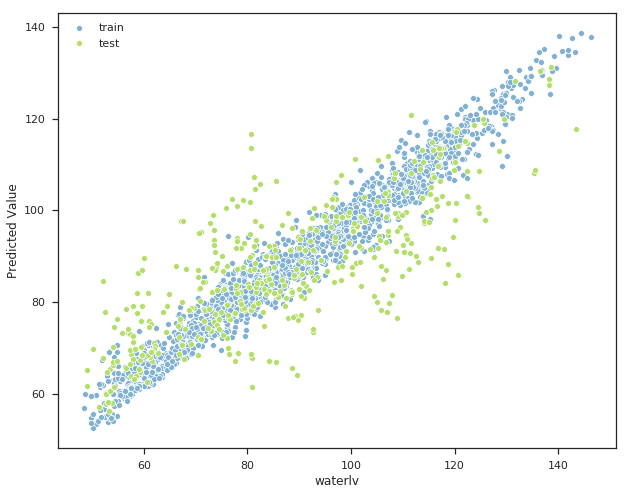

RMSE training set: 5.17700808089605
RMSE testing set: 13.415040521326892
MAE training set: 4.105967631470704
MAE testing set: 10.69222770715223


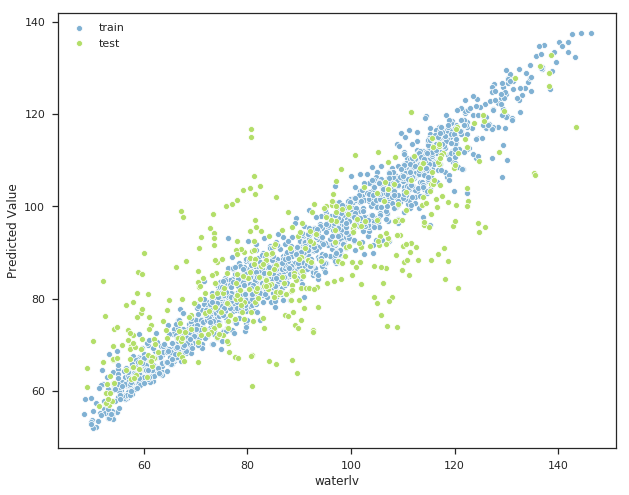

RMSE training set: 5.966528154601277
RMSE testing set: 13.795016471691087
MAE training set: 4.592931526496705
MAE testing set: 11.087915921040727


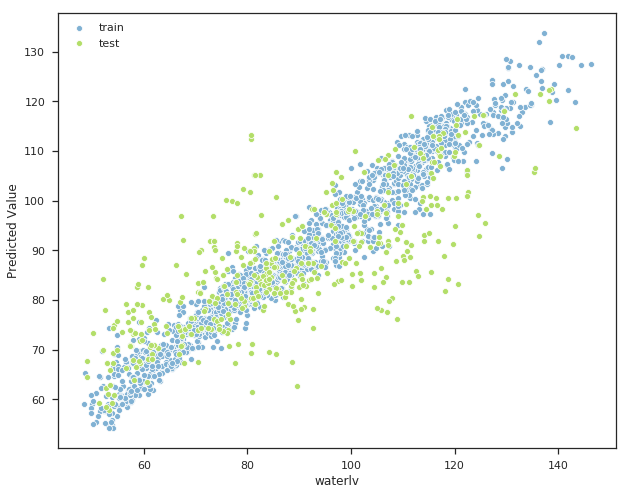

In [74]:
from sklearn.ensemble import RandomForestRegressor
evaluateClf(RandomForestRegressor, { 'n_estimators':200, 'max_depth': 20, 'random_state': 1})

**Grid Search**
**XGboost**

In [75]:
tuned_parameters = {'n_estimators': [10, 100, 200, 300], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.05, 0.07, 0.1], 'objective':['reg:linear'], 'min_child_weight': [1, 2]}

model = xgb.XGBRegressor()

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'learning_rate': 0.07,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 300,
 'objective': 'reg:linear'}

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=2, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
RMSE training set: 0.3928423932670737
RMSE testing set: 13.096181177644048
MAE training set: 0.2571748632497109
MAE testing set: 10.244518214839166


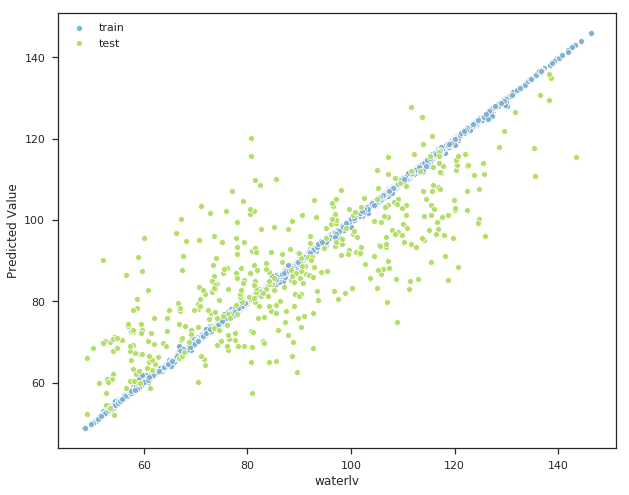

RMSE training set: 0.3200623521737606
RMSE testing set: 13.03473672442937
MAE training set: 0.21007325315096614
MAE testing set: 9.770930803460042


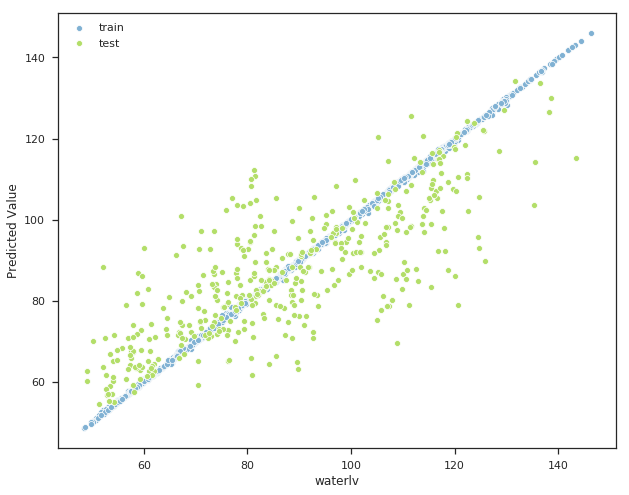

RMSE training set: 0.47804470147296696
RMSE testing set: 13.094159058608366
MAE training set: 0.26321567662257983
MAE testing set: 9.908242621916697


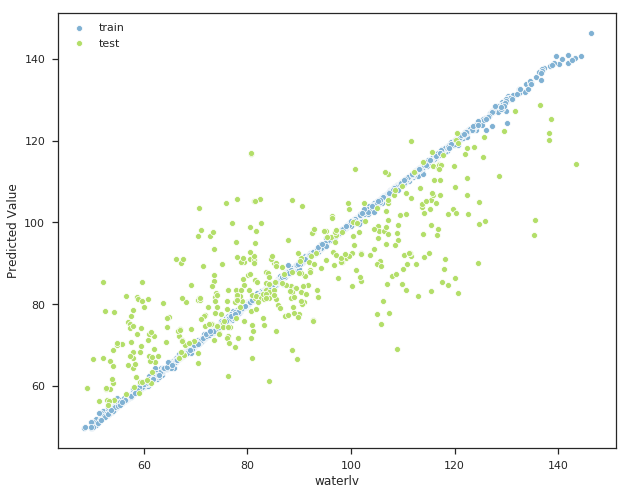

In [76]:
evaluateClf(xgb.XGBRegressor, {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'min_child_weight': 2,
                              'objective': 'reg:linear'}  )

In [77]:
tuned_parameters = {'n_estimators': [275,300, 325], 'max_depth': [8, 10, 12], 'learning_rate': [0.04, 0.05, 0.06], 'objective':['reg:linear'], 'min_child_weight': [2, 3]}

model = xgb.XGBRegressor()

grids= GridSearchCV(model ,tuned_parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=12)
grids.fit(X_train,Y_train)
grids.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 325,
 'objective': 'reg:linear'}

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.04, max_delta_step=0, max_depth=10,
       min_child_weight=3, missing=None, n_estimators=325, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
RMSE training set: 0.6089151792839963
RMSE testing set: 13.06436555192361
MAE training set: 0.41327158804158204
MAE testing set: 10.106699930468634


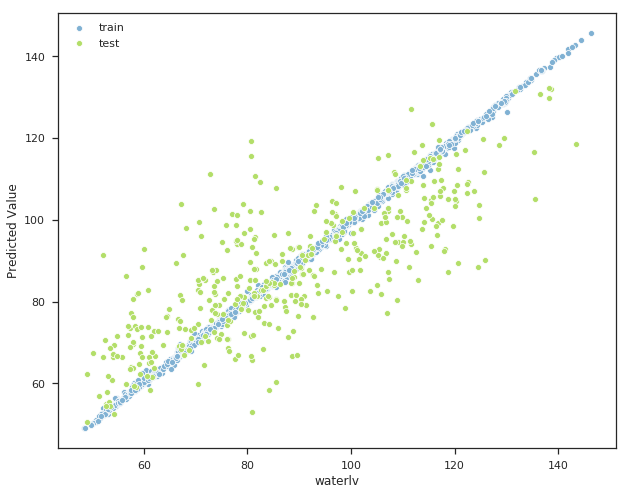

RMSE training set: 0.6820942825553126
RMSE testing set: 12.78596553702715
MAE training set: 0.4548232530212684
MAE testing set: 9.739450980377843


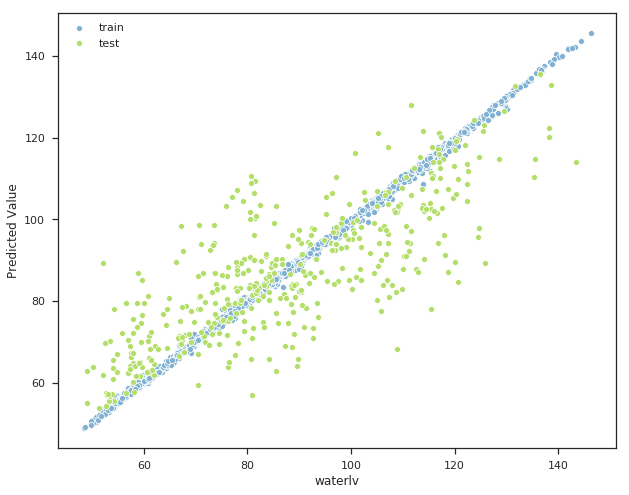

RMSE training set: 0.8680099186820239
RMSE testing set: 13.194009626986722
MAE training set: 0.49604323603495437
MAE testing set: 10.08524463419197


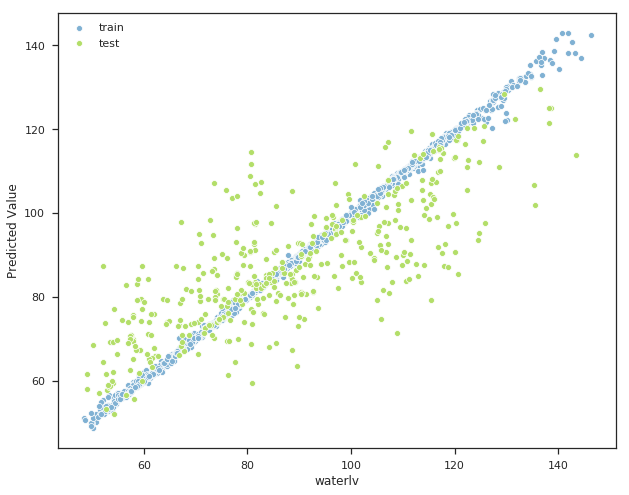

In [78]:
evaluateClf(xgb.XGBRegressor, {'n_estimators': 325, 'max_depth': 10, 'learning_rate': 0.04, 'min_child_weight': 3,
                              'objective': 'reg:linear'}  )

**Residuals**

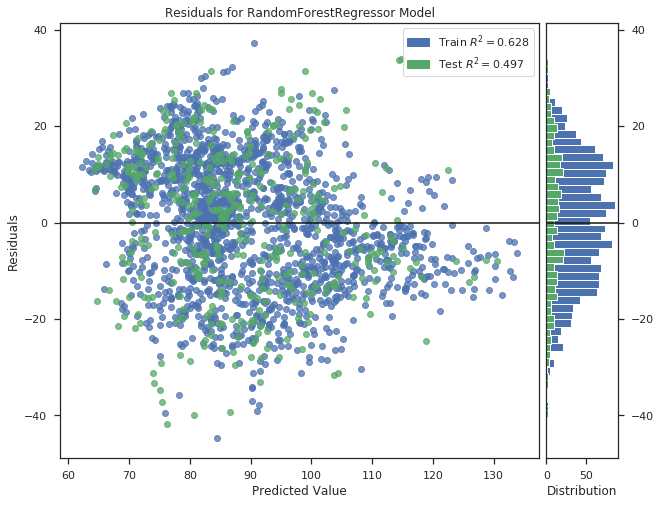

In [79]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
modelRF = RandomForestRegressor(n_estimators=200, max_depth= 6, random_state=1)
visualizer = ResidualsPlot(modelRF)

visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
visualizer.poof() 

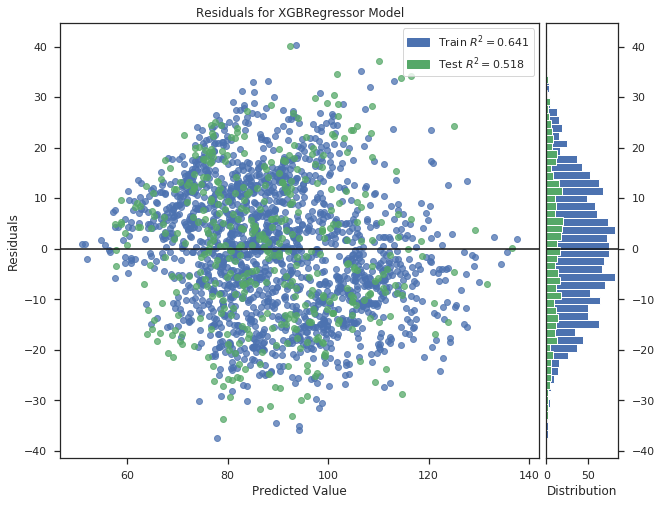

In [80]:
modelXGB = xgb.XGBRegressor(n_estimators =256, max_depth= 2, learning_rate= 0.1, nthread = 4)
visualizer = ResidualsPlot(modelXGB)

visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
visualizer.poof()    

**Wizualizacja wyników predykcji dla modeli lasów losowych i XGBoost**

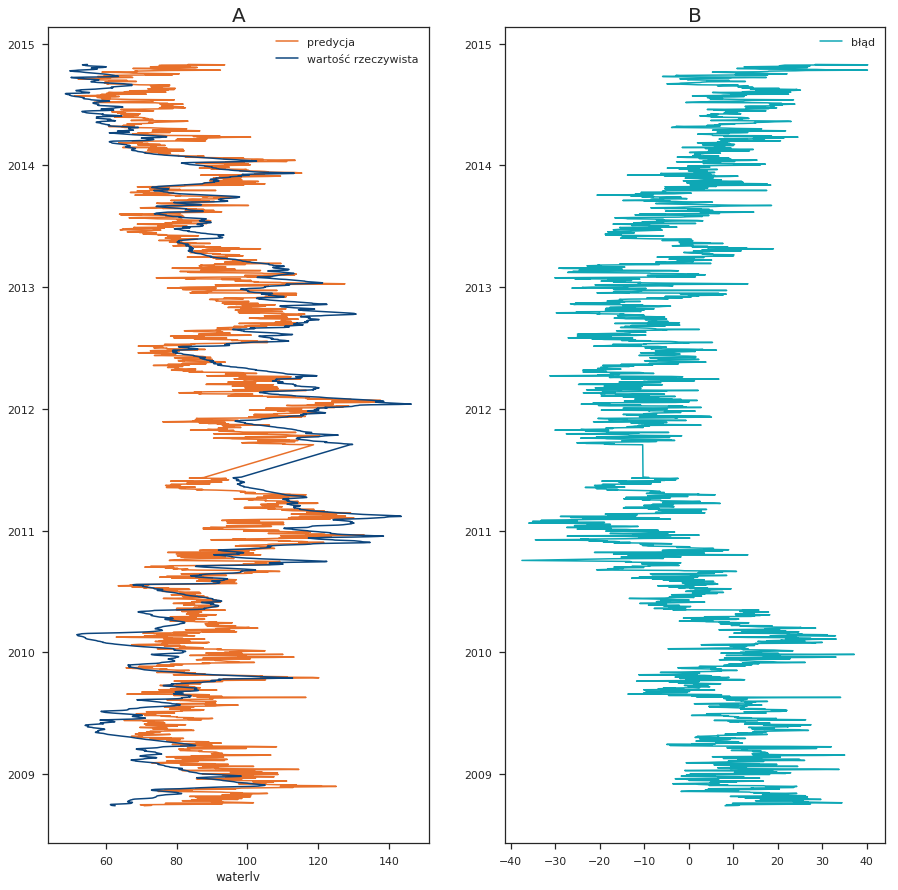

In [81]:
modelXGB.fit(X_train, Y_train)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
xgb_pred = modelXGB.predict(X)
xgb_err = xgb_pred - df.waterlv
ax1.plot(xgb_pred, df.index, color = '#e8702a', label = 'predycja')
ax2.plot(xgb_err, df.index, color='#0ea7b5', label = 'błąd')
df.reset_index().plot(x='waterlv', y='date', color = '#0c457d', ax=ax1, label = 'wartość rzeczywista')
ax1.legend()
ax2.legend()
ax1.set_title('A', fontsize=20)
ax2.set_title('B', fontsize=20)
plt.show()


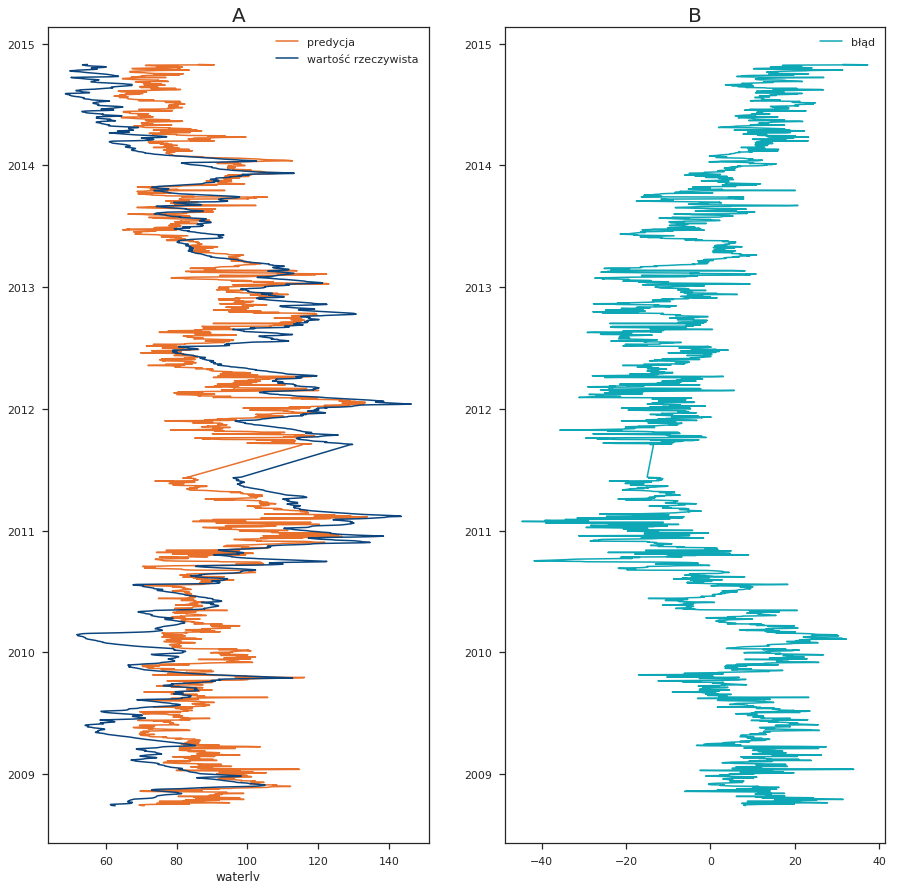

In [82]:
modelRF.fit(X_train, Y_train)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
rf_pred = modelRF.predict(X)
rf_err = rf_pred - df.waterlv
ax1.plot(rf_pred, df.index, color = '#e8702a', label = 'predycja')
ax2.plot(rf_err, df.index, color='#0ea7b5', label = 'błąd')
df.reset_index().plot(x='waterlv', y='date', color = '#0c457d', ax=ax1, label = 'wartość rzeczywista')
ax1.legend()
ax2.legend()
ax1.set_title('A', fontsize=20)
ax2.set_title('B', fontsize=20)
plt.show()


In [83]:
colnames = list(df.columns) 
colnames.remove('waterlv')
colnames

['cos',
 'meantemp',
 'precip',
 'precip1',
 'precip2',
 'precip3',
 'precip4',
 'precip5',
 'precipsum',
 'sealv',
 'sin',
 'temp',
 'vwind',
 'watertemp']

In [84]:
rf_importances = modelRF.feature_importances_

In [85]:
imp = list(zip(rf_importances, colnames))
imp.sort()

In [86]:
xgb_importances = modelXGB.feature_importances_
xgb_importances

array([0.0397501 , 0.1167717 , 0.06716121, 0.09095513, 0.03049254,
       0.02721174, 0.04819995, 0.05585731, 0.06091319, 0.22713539,
       0.02571912, 0.10049516, 0.02890628, 0.08043119], dtype=float32)

In [87]:
impx = list(zip(xgb_importances, colnames))
impx.sort()

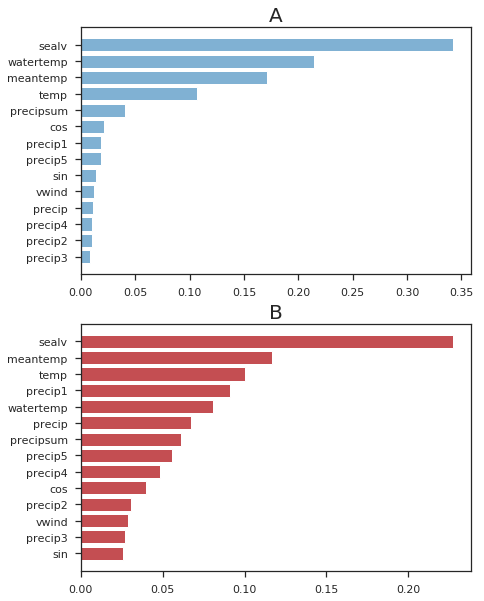

In [88]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,10))
ax1.barh([i[1] for i in imp], [i[0] for i in imp])
ax2.barh([i[1] for i in impx], [i[0] for i in impx], color = 'r')
ax1.set_title('A', fontsize=20)
ax2.set_title('B', fontsize=20)
plt.show()



In [89]:
clust_error = df_clust.copy()
rf_pred = modelRF.predict(X)
rf_err = rf_pred - df.waterlv
xgb_pred = modelXGB.predict(X)
xgb_err = xgb_pred - df.waterlv
clust_error['rf_err'] = rf_err
clust_error['rf_err_abs'] = abs(rf_err)
clust_error['xgb_err'] = xgb_err
clust_error['xgb_err_abs'] = abs(xgb_err)
grpb_err = clust_error.groupby('klasa').agg(['mean','std'])
grpb_err

cos             meantemp              precip             precip1  \
           mean       std       mean       std      mean       std      mean   
klasa                                                                          
0     -0.391231  0.551916  13.354281  4.643335  1.370960  3.595386  0.347210   
1     -0.509713  0.500200  13.313839  4.102181  1.718563  4.287121  0.805747   
2     -0.337193  0.458392  12.319030  4.942734  4.693659  6.944079  6.940759   
3     -0.526184  0.472900   2.487361  3.533038  1.836366  3.051270  2.018449   
4     -0.325207  0.541357   1.198271  5.048533  0.601523  1.869977  0.369117   

                  precip2             precip3             precip4            \
            std      mean       std      mean       std      mean       std   
klasa                                                                         
0      1.309493  0.309129  1.100832  0.273348  0.935337  0.198259  0.651528   
1      2.670360  3.289310  6.617665  4.988879  7.404221  5.921580  7.513633   
2      7.342112  4.307019  5.917179  2.657263  4.619010  1.636450  3.663274   
3      3.005513  2.260324  3.482808  2.302060  3.561757  2.526389  3.689196   
4      1.082605  0.419211  1.169134  0.424492  1.357119  0.400695  1.196421   

        precip5            precipsum                  sealv             \
           mean       std       mean        std        mean        std   
klasa                                                                    
0      0.466339  1.469882   1.594286   2.283485  504.072924  12.202465   
1      4.638908  6.602492  19.644425  13.231051  511.030460  13.984342   
2      2.467588  5.670448  18.009079  13.497659  516.669377  18.178918   
3      2.464745  3.707317  11.571968   8.857808  515.446991  20.641593   
4      0.493026  1.401425   2.106541   2.579704  490.597895  14.809340   

            sin                 temp               vwind            \
           mean       std       mean       std      mean       std   
klasa                                                                
0      0.079357  0.733424  14.004821  5.111435  4.038906  1.718577   
1      0.125947  0.690085  13.362701  4.742684  3.714368  1.409684   
2     -0.648679  0.506614  11.467696  4.392404  6.492981  2.594282   
3     -0.231624  0.668879   2.188889  4.078270  4.648727  2.230370   
4      0.179621  0.755336   1.426128  5.446603  4.326485  2.084386   

          waterlv             watertemp              rf_err             \
             mean        std       mean       std      mean        std   
klasa                                                                    
0       80.765737  19.013127  10.558170  1.565339 -0.267770  13.488147   
1       87.828333  19.597443  11.109483  1.508253 -0.973637  13.144981   
2       86.617290  19.097687  10.926287  1.625970  1.075526  11.810534   
3      100.768310  21.208006   8.465093  1.280828 -0.967605  13.034400   
4       89.926936  21.191709   7.610132  1.005523  0.429384  14.538310   

      rf_err_abs             xgb_err            xgb_err_abs            
            mean       std      mean        std        mean       std  
klasa                                                                  
0      11.256081  7.417491 -0.241950  12.154443    9.873819  7.076634  
1      10.823194  7.500808 -0.212079  13.375888   10.923085  7.700771  
2       9.751964  6.729739  0.722348  12.286260   10.144661  6.948495  
3      10.961226  7.099772 -0.566357  13.936662   11.519188  7.845540  
4      12.233545  7.848930  0.482295  13.551947   11.141121  7.715568

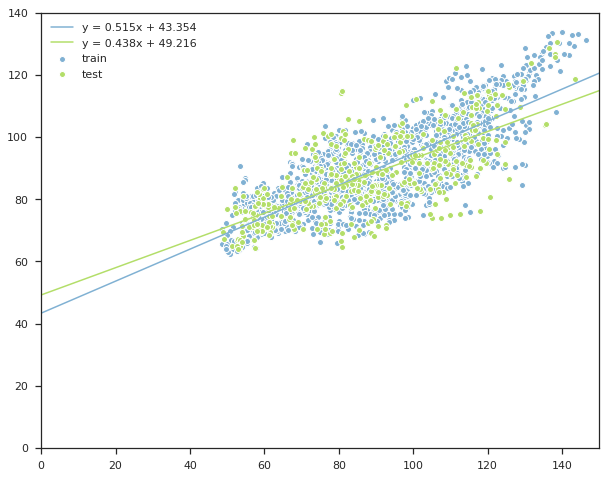

In [90]:
train = Y_train
train_pred = modelRF.predict(X_train)
test = Y_validation
test_pred = modelRF.predict(X_validation)

lbls = ['train', 'test']
plt.scatter(train,train_pred, c='C0', edgecolors='w', label='train')
plt.scatter(test,test_pred, c='C1', edgecolors='w', label='test')

z_train = np.polyfit(train, train_pred, 1)
p_train = np.poly1d(z_train)
print()

z_test = np.polyfit(test, test_pred, 1)
p_test = np.poly1d(z_test)
print()

plt.xlim([0, 150])
plt.ylim([0, 140])
x = np.linspace(0, 150)
plt.plot(x,p_train(x), "-", label = ("y = %.3fx + %.3f"%(z_train[0],z_train[1])))
plt.plot(x,p_test(x), label = ("y = %.3fx + %.3f"%(z_test[0],z_test[1])))
plt.legend()
plt.show()

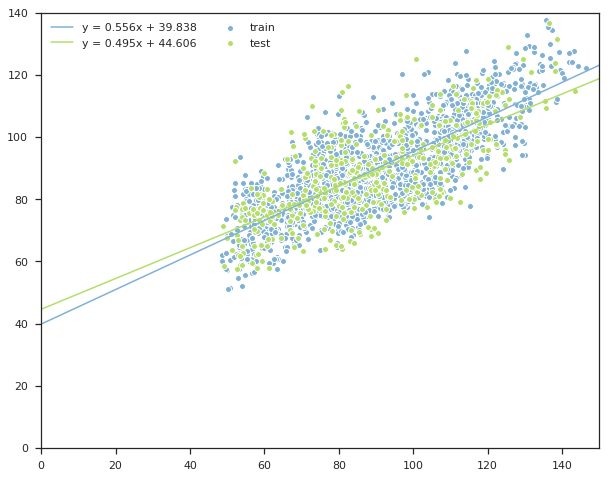

In [91]:
train = Y_train
train_pred = modelXGB.predict(X_train)
test = Y_validation
test_pred = modelXGB.predict(X_validation)

lbls = ['train', 'test']

z_train = np.polyfit(train, train_pred, 1)
p_train = np.poly1d(z_train)
print()

z_test = np.polyfit(test, test_pred, 1)
p_test = np.poly1d(z_test)
print()

plt.xlim([0, 150])
plt.ylim([0, 140])
x = np.linspace(0, 150)
plt.plot(x,p_train(x), "-", label = ("y = %.3fx + %.3f"%(z_train[0],z_train[1])))
plt.plot(x,p_test(x), label = ("y = %.3fx + %.3f"%(z_test[0],z_test[1])))
plt.scatter(train,train_pred, c='C0', edgecolors='w', label='train')
plt.scatter(test,test_pred, c='C1', edgecolors='w', label='test')

plt.legend( ncol=2)
plt.show()

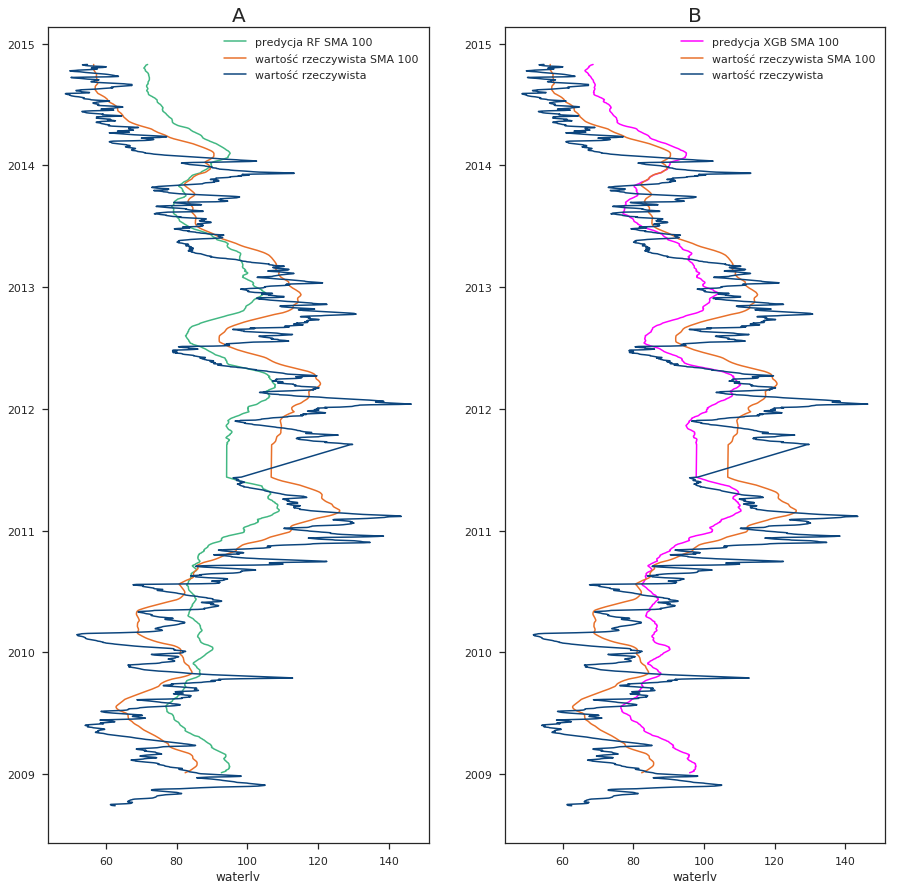

In [92]:
#wygładzanie z wykorzystaniem średniej ruchomej
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
rf_pred = modelRF.predict(X)
rf_err = rf_pred - df.waterlv
df_rpred = pd.DataFrame(rf_pred)

rolling_mean = df_rpred.rolling(window=100).mean()
rolling_mean2 = df_rpred.rolling(window=50).mean()

xgb_pred = modelXGB.predict(X)
xgb_err = xgb_pred - df.waterlv
df_xpred = pd.DataFrame(xgb_pred)

rolling_mean3 = df_xpred.rolling(window=100).mean()

ax1.plot(rolling_mean, df.index, color = '#42b883', label = 'predycja RF SMA 100')
ax2.plot(rolling_mean3, df.index, color = '#ff00ff', label = 'predycja XGB SMA 100')
ax1.plot(df.waterlv.rolling(window=100).mean(), df.index, color = '#e8702a', label = 'wartość rzeczywista SMA 100')
ax2.plot(df.waterlv.rolling(window=100).mean(), df.index, color = '#e8702a', label = 'wartość rzeczywista SMA 100')

df.reset_index().plot(x='waterlv', y='date', color = '#0c457d', ax=ax1, label = 'wartość rzeczywista')
df.reset_index().plot(x='waterlv', y='date', color = '#0c457d', ax=ax2, label = 'wartość rzeczywista')

ax1.legend()
ax2.legend()
ax1.set_title('A', fontsize=20)
ax2.set_title('B', fontsize=20)
plt.show()
